# Morphological Operation (40 pts)

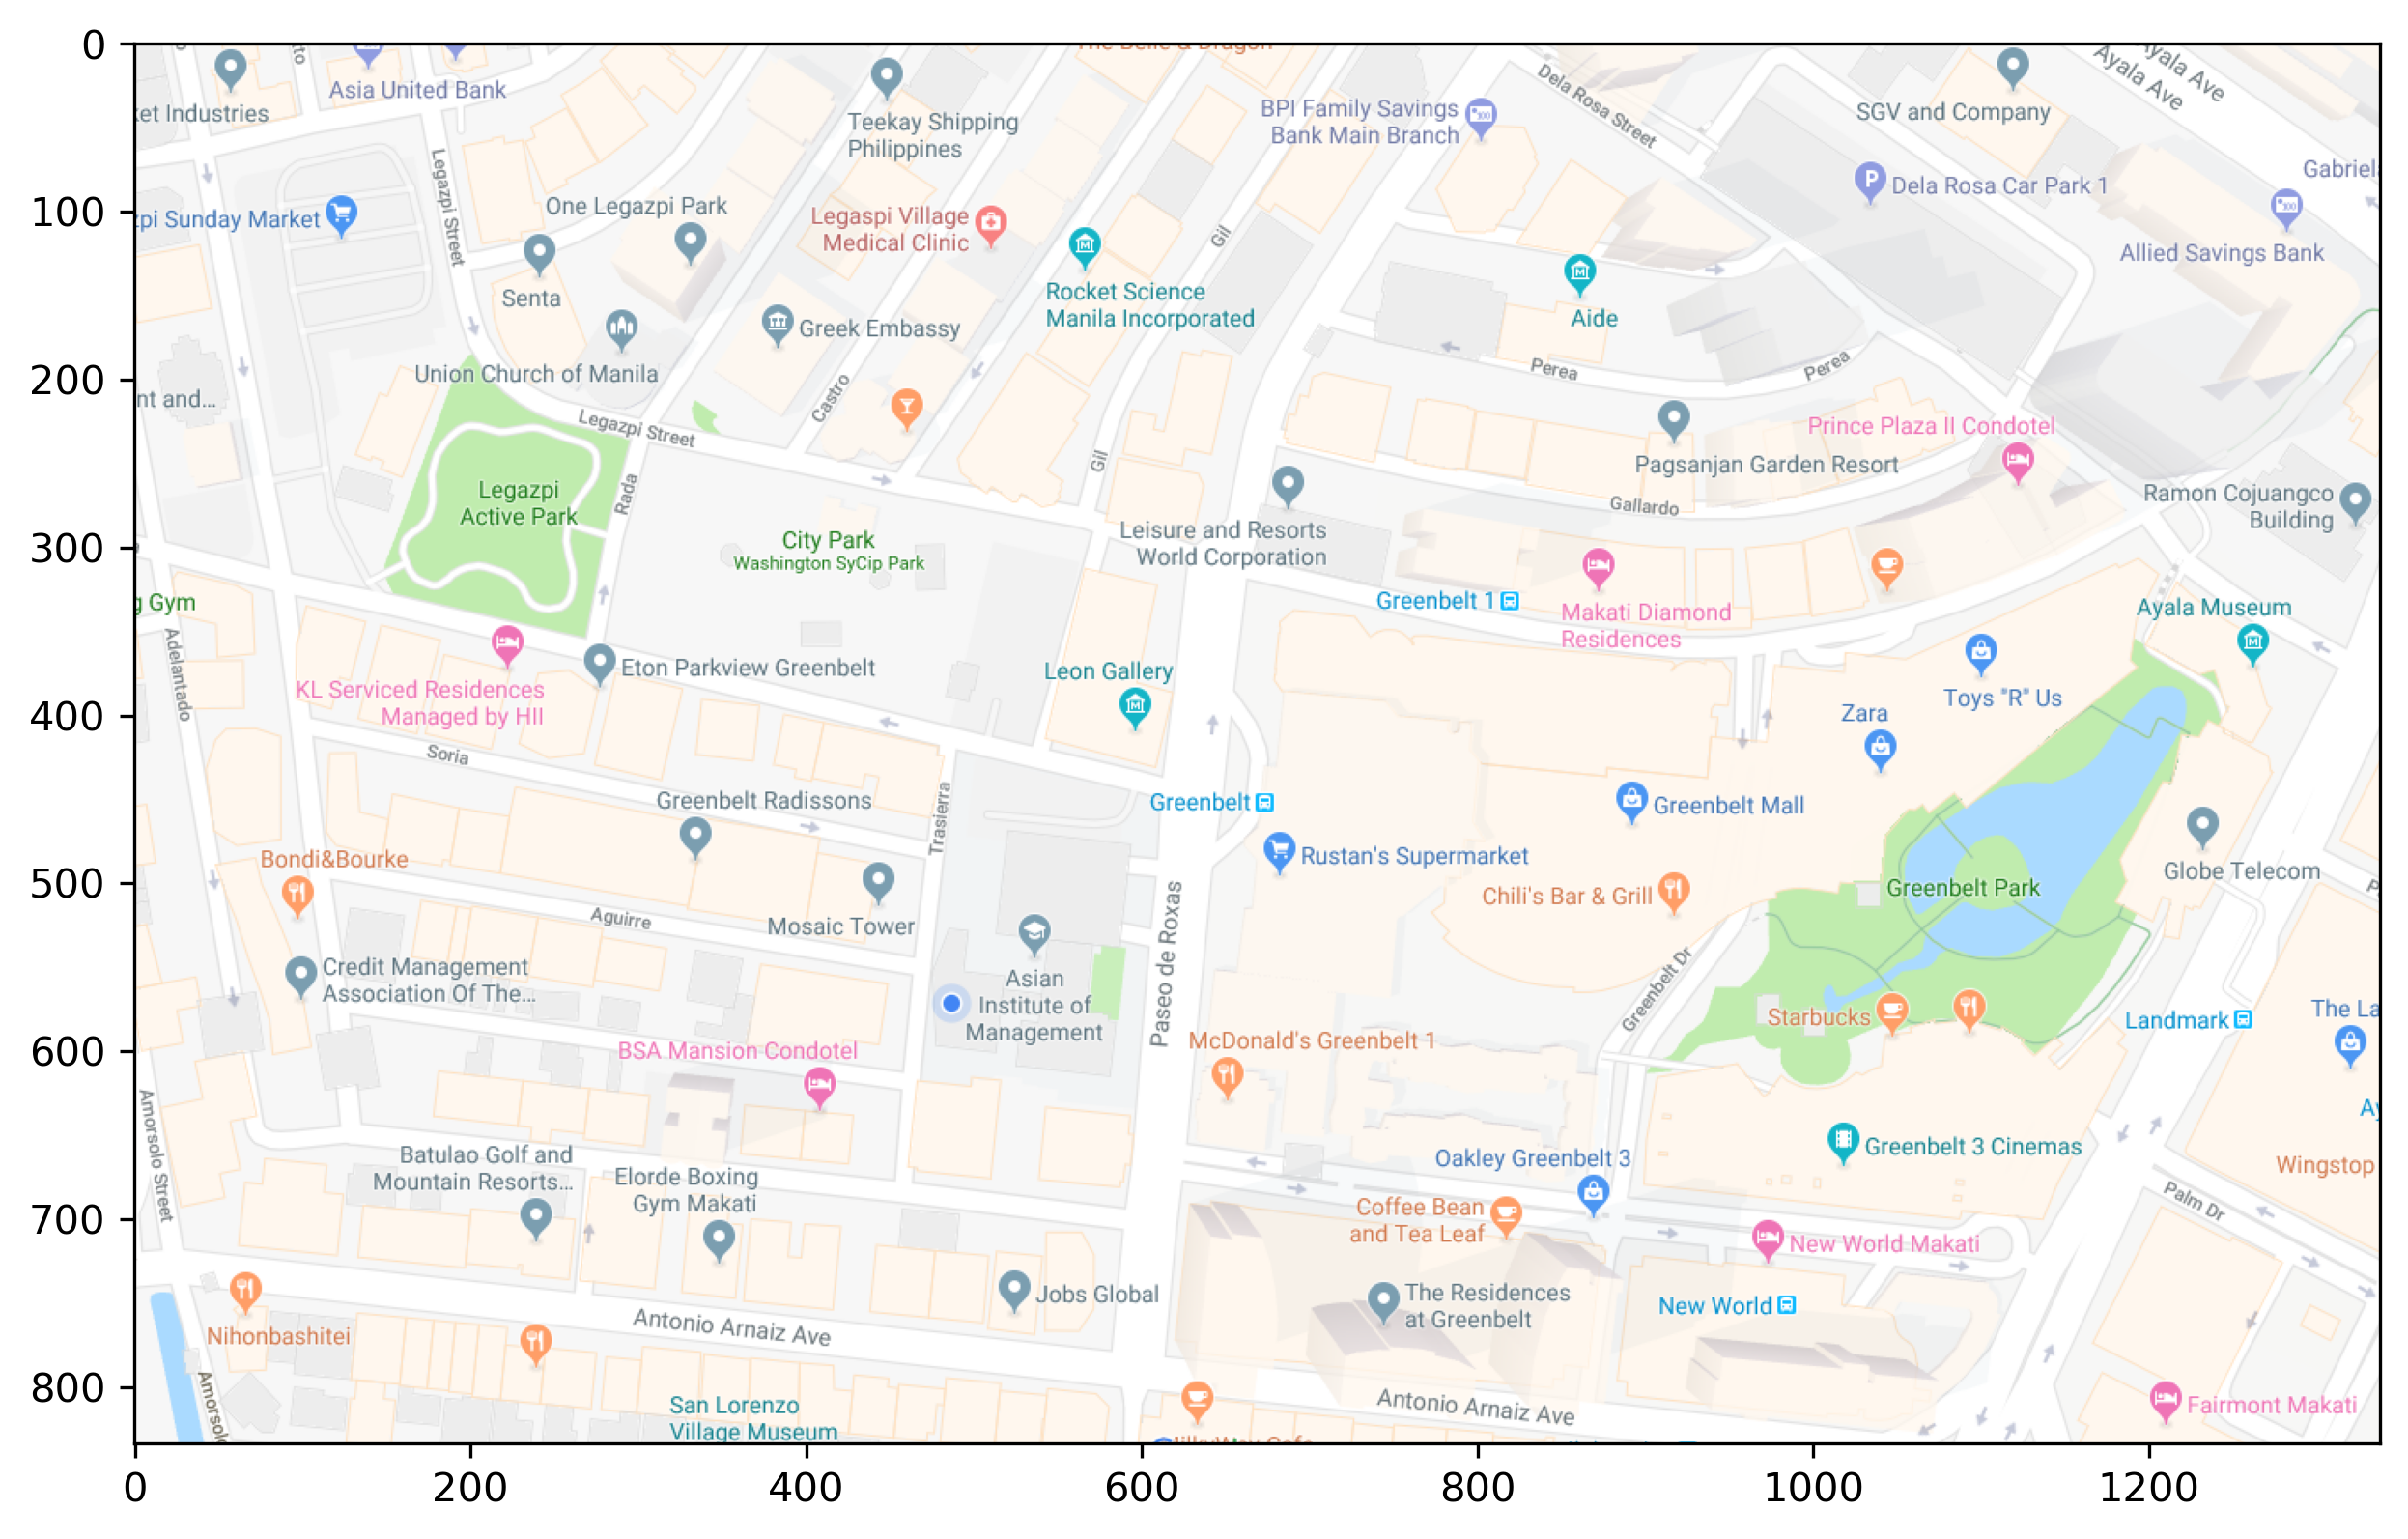

In [1]:
from skimage import data, io, filters
import matplotlib.pyplot as plt

image_raw = io.imread('map2.PNG')
fig, ax = plt.subplots(figsize=(10,10),dpi=300)
ax.imshow(image_raw,cmap='gray')

Given the following google map image, find the pixel length and pixel area of all roads included in the image.
As a starting point, try to binarize the image first then use morphological operations to clean the image.

In [2]:
from skimage.color import rgb2gray
from skimage.io import imshow
im = rgb2gray(image_raw[:, :, :3])

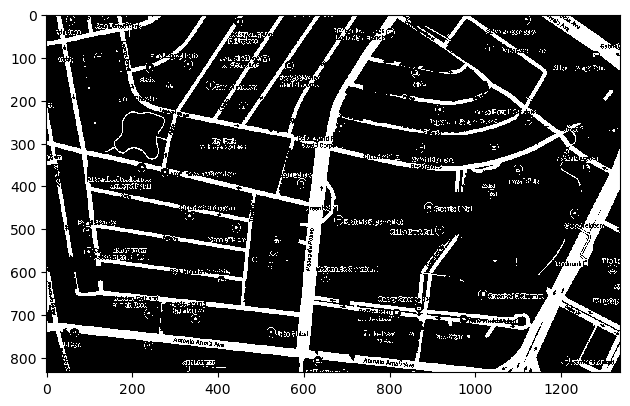

In [3]:
# Do manual threshold to binarize 
im_bw = im>0.973
imshow(im_bw)

In [4]:
from skimage.morphology import (erosion, dilation, skeletonize, thin, 
                                opening, closing)
import numpy as np
from skimage.draw import disk

def im_erosion(image, selem, n):
    for i in range(n):
        image = erosion(image, selem)
    return image

def im_dilation(image, selem, n):
    for i in range(n):
        image = dilation(image, selem)
    return image

def im_opening(image, selem, n):
    for i in range(n):
        image = opening(image, selem)
    return image

def im_closing(image, selem, n):
    for i in range(n):
        image = closing(image, selem)
    return image

In [5]:
selem_temp = np.array([[-1, -1, -1, -1],
                       [-1, 8.5, 8.5, -1],
                       [-1, 8.5, 8.5, -1],
                       [-1, -1, -1, -1]])

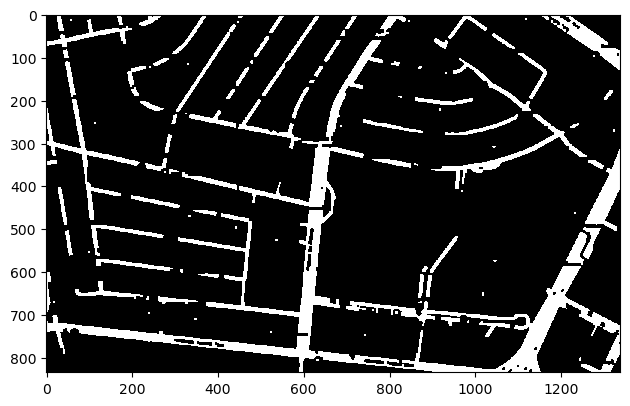

In [6]:
map1 = im_closing(im_opening(im_bw, selem_temp, 1), selem_temp, 1)
imshow(map1)

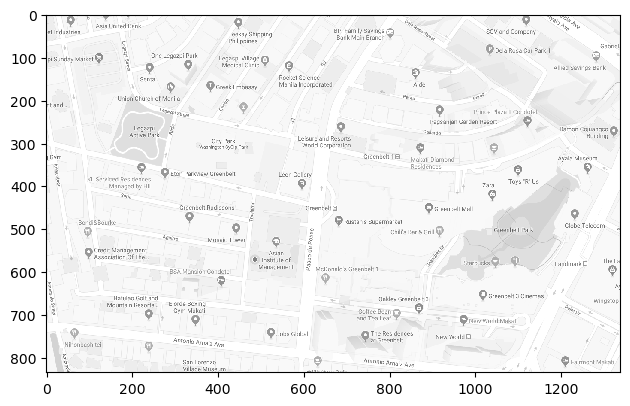

In [7]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
im = rgb2gray(imread('map2.PNG')[:, :, :3])
imshow(im);

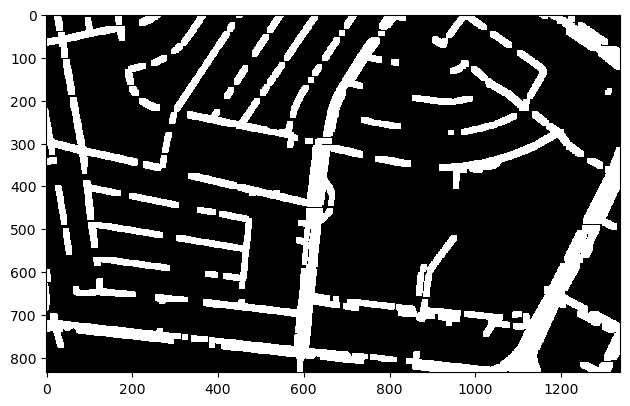

In [8]:
map2 = im_dilation((im_erosion(map1, selem_temp, 2)), selem_temp, 4)
imshow(map2)

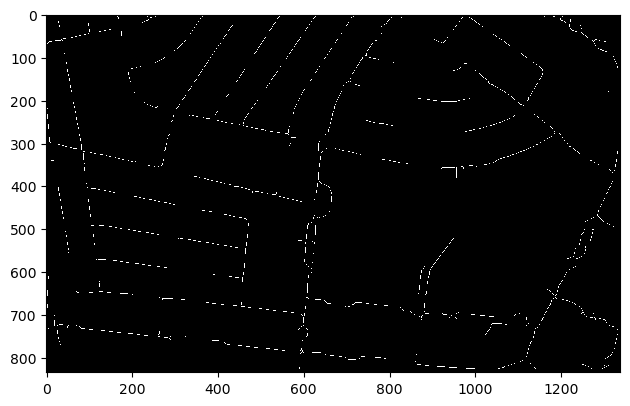

In [9]:
skeleton = skeletonize(map2)
imshow(skeleton)

In [10]:
skel_count = np.sum(skeleton)
print(f'Pixel length of all roads = {skel_count} pixels')

Pixel length of all roads = 10409 pixels


Questions:
1. How did you binarize the image?
1. What morphological operations did you use? (Hint: try to look at *skeletonize* of skimage)
1. Explain how you used each operation and its effect on the image.
1. What are the challenges you've encounterd in performing the processing?

## Q1 How did you binarize the image?

For us to binarize we first took the colored image, selects the first three color channels(RGB), and converts them to a grayscale representation. We then set a threshold manually, making sure that the binarized image has not lost too much information.

## Q2 What morphological operations did you use? 

We applied opening, closing, dilation and erosion to the image. For the kernel, we used a simple kernel that has a central value of 8.5 and surrounding values of -1. We wanted to start with a kernel that focuses on the center to dilute the names which ended up diluting them alltogether.

## Q3 Explain how you used each operation and its effect on the image.

Opening  help remove small objects and background noise while preserving the overall shape and connectivity of larger objects. In this case, we applied the opening operation using the selem_temp kernel with 1 iteration.

Closing was then made for small gaps and fill in holes within the foreground regions. After that we applied dilation which expands the boundaries of regions in the image, making them larger and filling in gaps or holes. It helped in the smoothing and thickening regions. The code applied the dilation operation using the selem_temp kernel with 4 iterations because we wanted to match a better skeletal output. Lastly, we did erosion for a final trimming of the image's boundaries.

## Q4 What are the challenges you've encountered in performing the processing?

ome challenges in image processing include determining the optimal threshold value for binarization, selecting suitable structuring elements and the combination and number of iterations for morphological operations and handling noise or artifacts that can affect the accuracy of the results. We also had a hard time determining whether we are over dilation or eroding the image because there are disconnections that are happening and information are also being lost. It is a tradeoff of what we want to achieve.

# Blob Detection (40 pts)

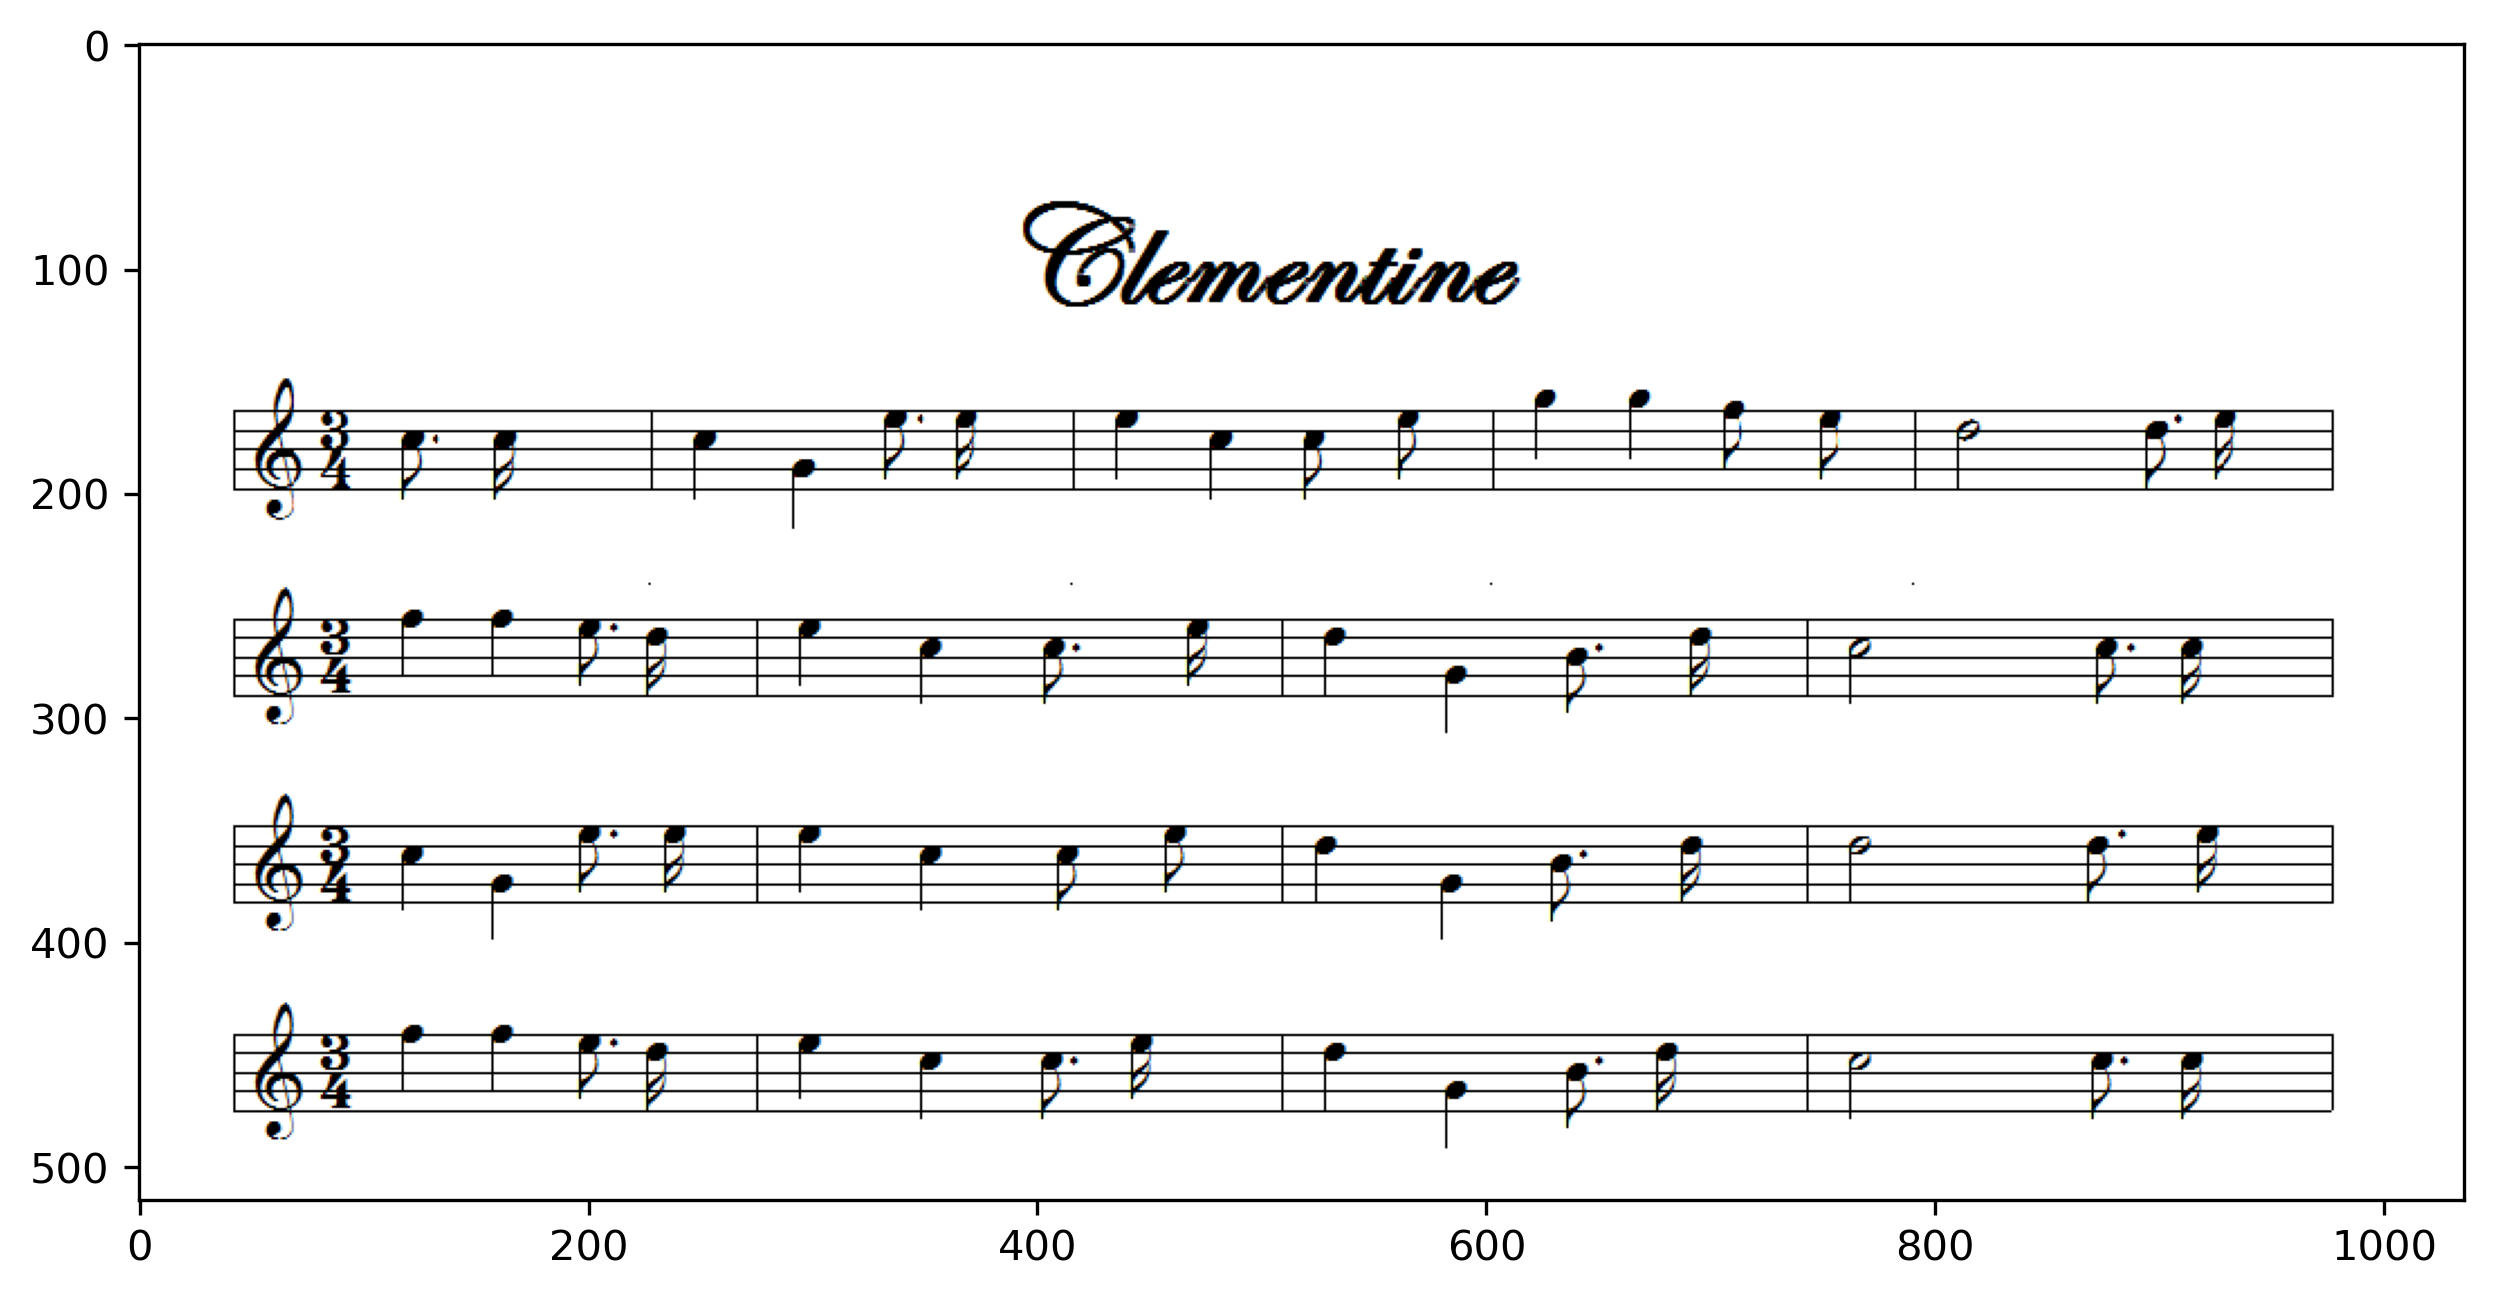

In [11]:
from skimage import data, io, filters
import matplotlib.pyplot as plt

music = imread('Clementine.png')
fig, ax = plt.subplots(figsize=(10,10),dpi=300)
ax.imshow(music,cmap='gray')

Create an algorithm that would automatically read a given sheet music, i.e return the pitch and beat of each note. The goal of the algorithm is to create a list containing the pitch and beat, e.g. (C 3, D 1, G 1/2). For context, the vertical position of the note give us the pitch:

<img src="read_music.png" width="300" />

While the shape of the note gives us the beat:

<img src="beats.jpg" width="300" />

You can focus on the first line to create your algorithm. *Hint: Use the relative pixel position to find the pitch

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from matplotlib.patches import Rectangle
from skimage.io import imread, imshow
from skimage.feature import match_template, peak_local_max
from skimage.measure import label, regionprops
from skimage.morphology import erosion, dilation
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.util import invert
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

# Pitch

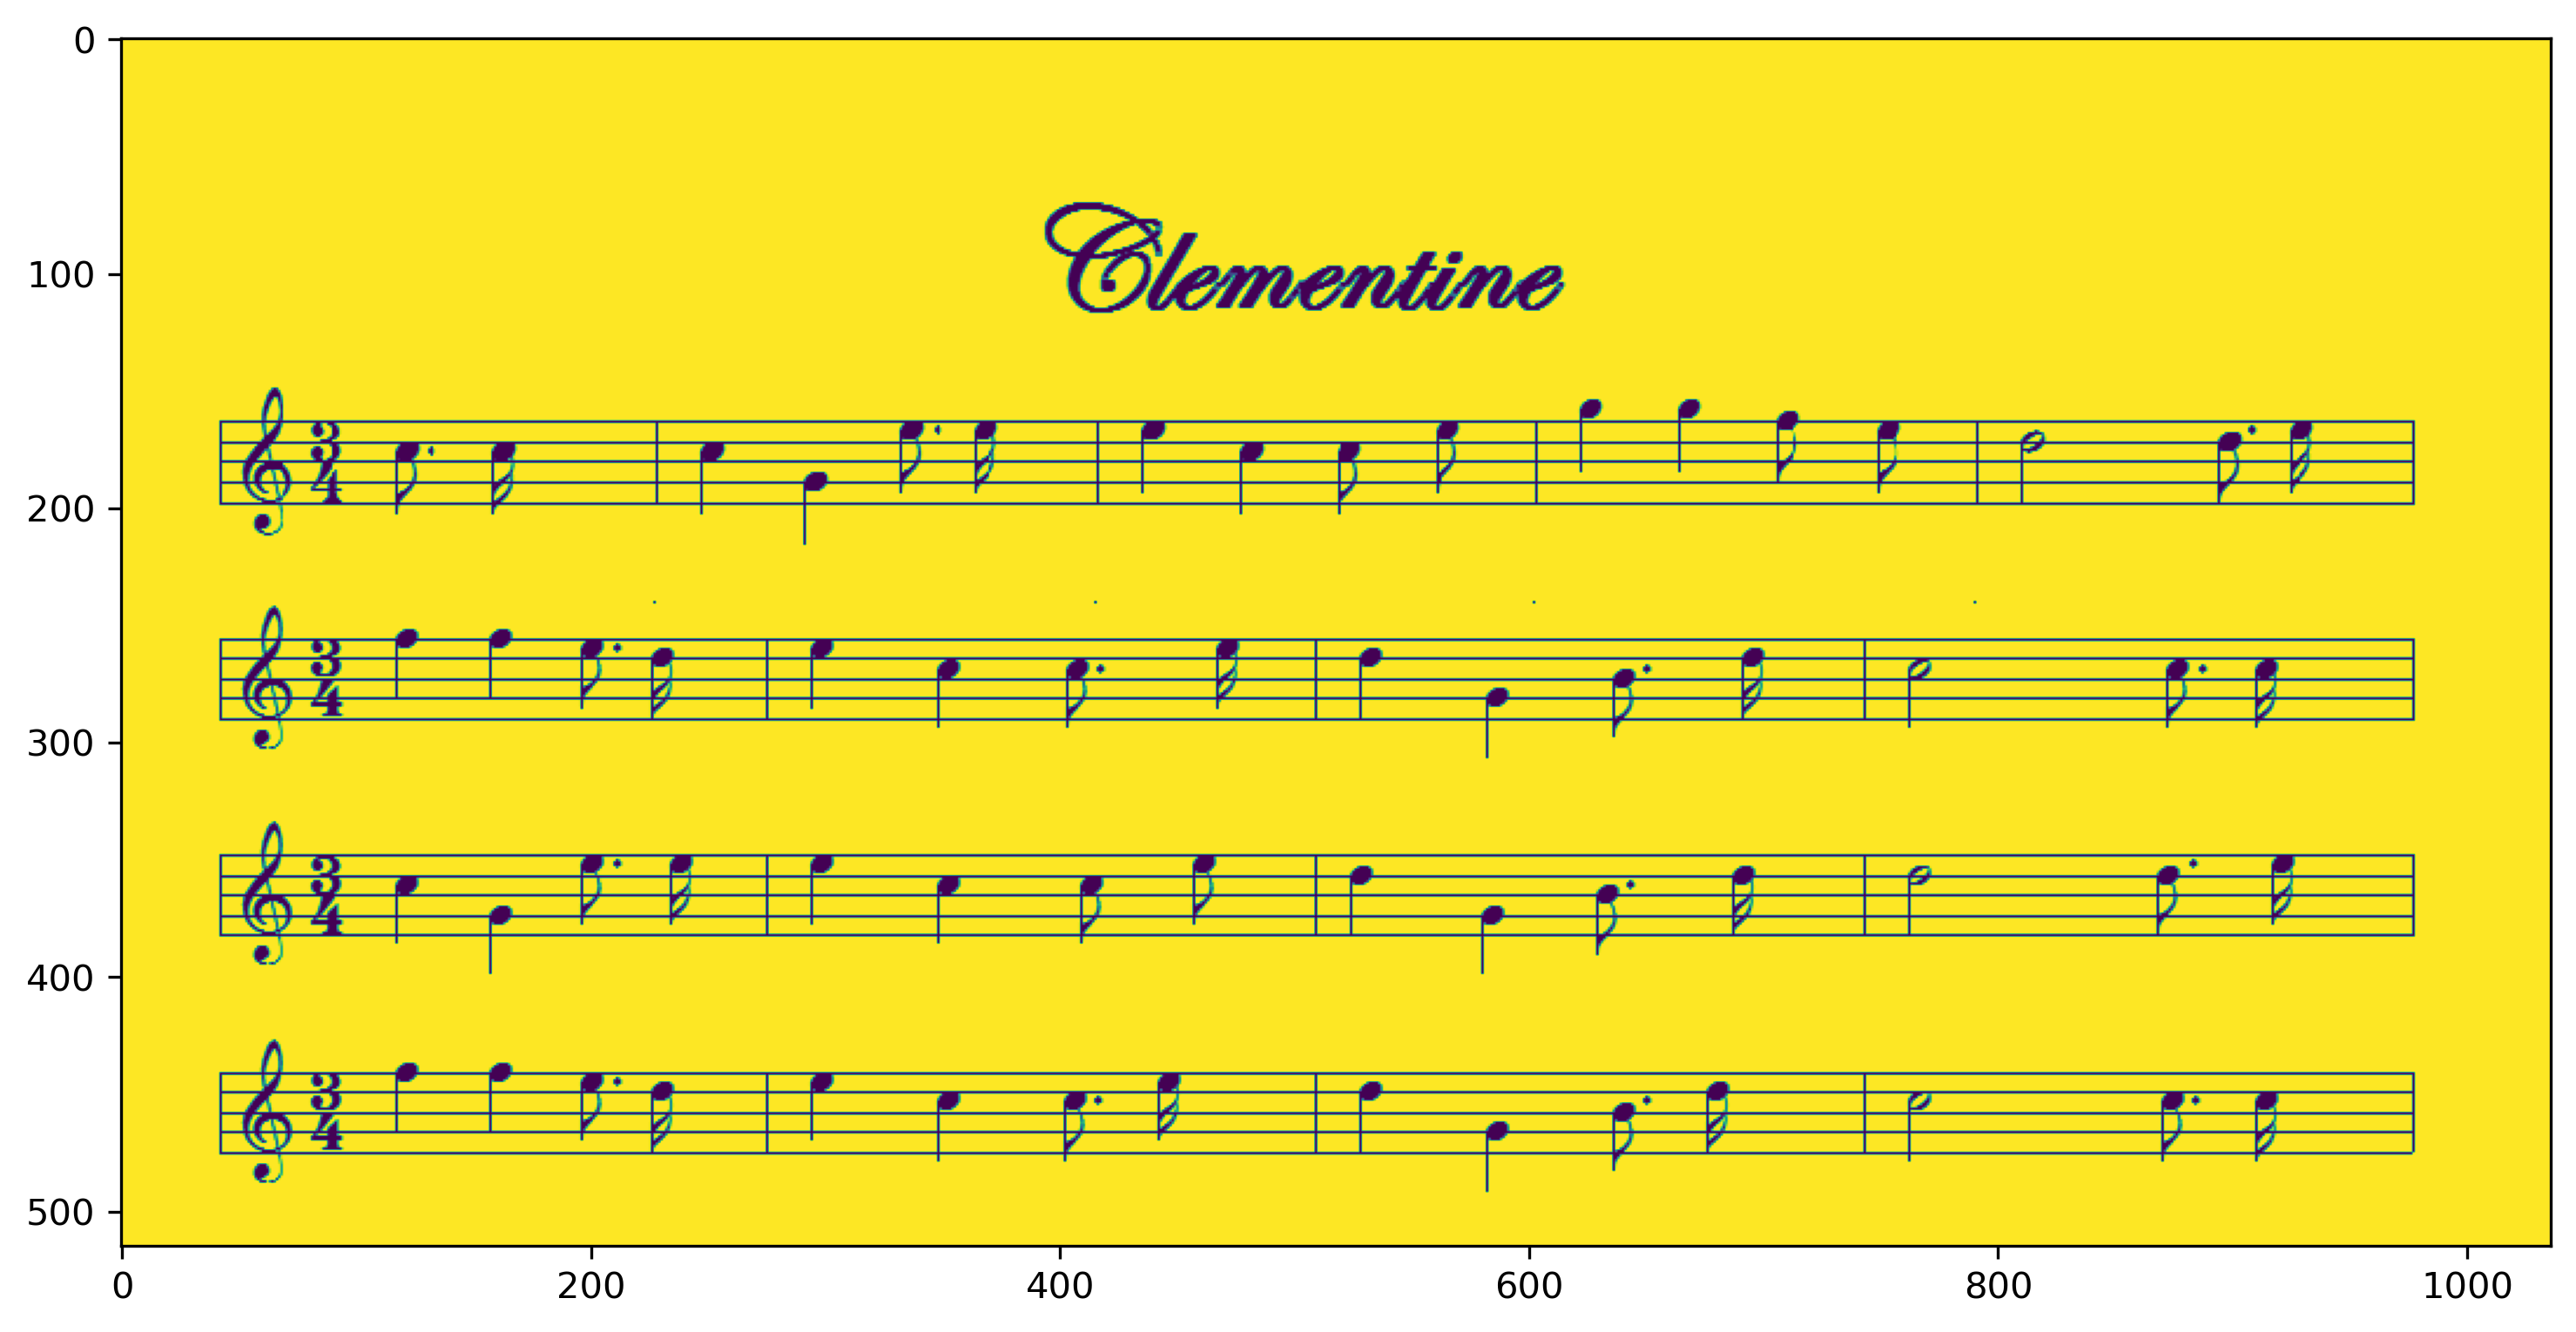

In [13]:
music = rgb2gray(imread('Clementine.png'))
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
ax.imshow(music);

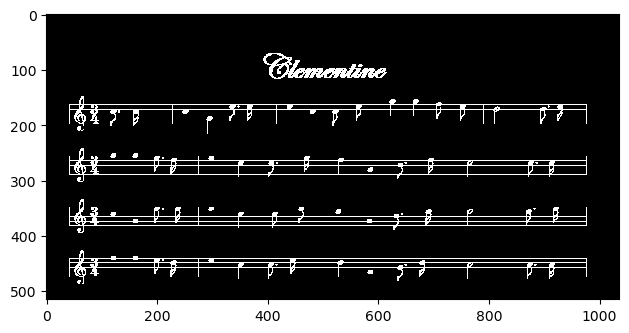

In [14]:
music = music < 1
imshow(music)

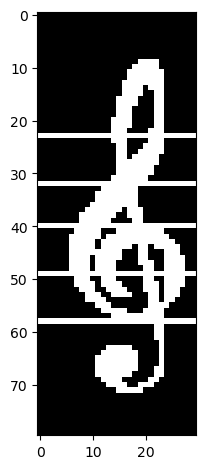

In [15]:
template = music[140:220, 45:75]
imshow(template);

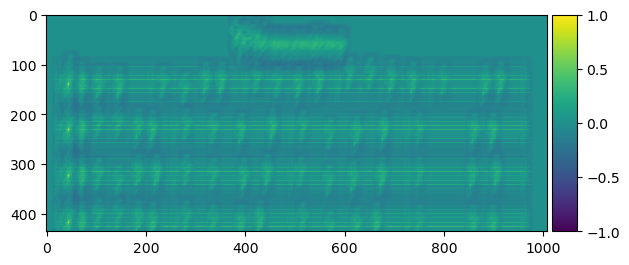

In [16]:
result = match_template(music, template)
imshow(result, cmap='viridis');

In [17]:
template.shape

(80, 30)

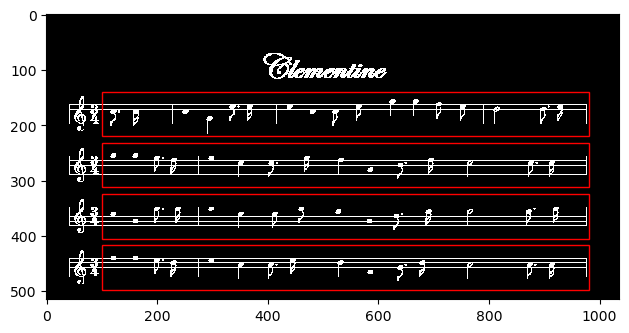

In [18]:
# Display the image
imshow(music)
template_height, template_width  = template.shape
music_lines = []
for y, x in peak_local_max(result, threshold_abs=0.8):
    rect = plt.Rectangle((x+55, y), 
                         template_width+850, 
                         template_height, 
                         color='r', 
                         fc='none')
    plt.gca().add_patch(rect);
    
    music_lines.append(music[y:y+template_height, 
                             x+55:x+template_width+850+55])

plt.show()

C:\Users\Rod Gabriel\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


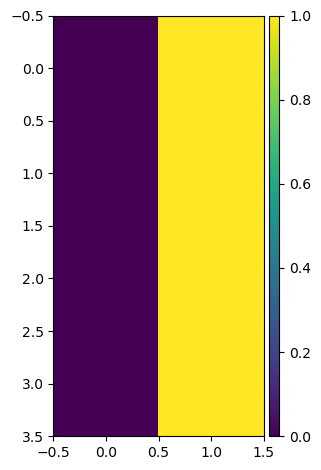

In [19]:
element = np.array([[0,1],
                    [0,1],
                    [0,1],
                    [0,1]])
selem_hor = np.array([[0,0,0],
                     [1,1,1],
                     [0,0,0]])
selem_stem = np.array([[0, 1, 0],
                       [0, 1, 0],
                       [0, 1, 0],
                       [0, 1, 0],
                       [0, 1, 0],
                       [0, 1, 0]])
imshow(element);

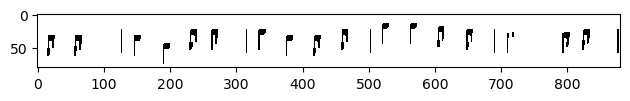

In [20]:
selem_stem_large = np.ones((7, 1))
selem_bridge = np.ones((1, 4))
selem_note = np.ones((2,2))

line1 = im_dilation(im_closing(im_closing(im_opening(music_lines[0], selem_stem, 1), selem_stem, 1),selem_bridge, 3), selem_note, 1)
line2 = im_dilation(im_closing(im_closing(im_opening(music_lines[1], selem_stem, 1), selem_stem, 1),selem_bridge, 3), selem_note, 1)
line3 = im_dilation(im_closing(im_closing(im_opening(music_lines[2], selem_stem, 1), selem_stem, 1),selem_bridge, 3), selem_note, 1)
line4 = im_dilation(im_closing(im_closing(im_opening(music_lines[3], selem_stem, 1), selem_stem, 1),selem_bridge, 3), selem_note, 1)
imshow(invert(line1));

Number of blobs detected: 16
Number of blobs detected: 14
Number of blobs detected: 14
Number of blobs detected: 14


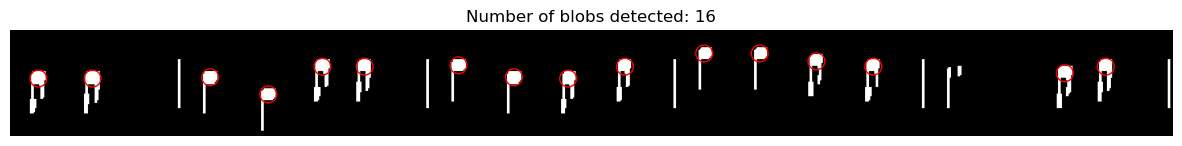

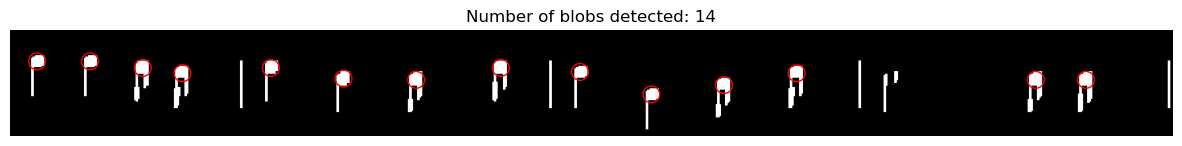

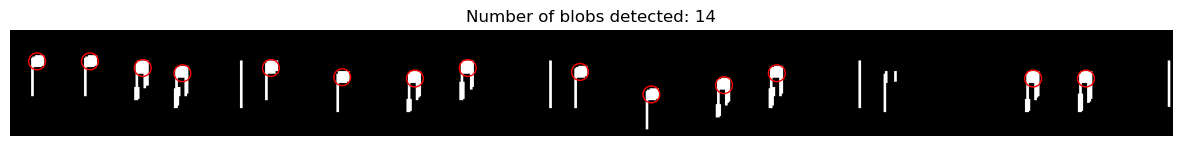

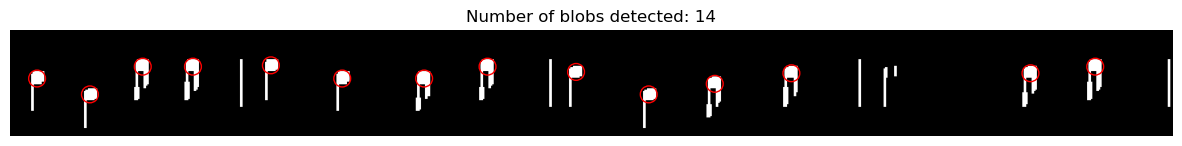

In [21]:
def blob_detection(eroded_image):
    blobs = blob_dog(eroded_image, min_sigma=4.5, overlap=0.1, threshold=0.3)
    fig, ax = plt.subplots( figsize=(15,3))
    ax.imshow(eroded_image, cmap='gray')
    ax.axis('off')
    for blob in blobs:
        y, x, area = blob
        ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                                fill=False))
    blobs = [(xaxis, yaxis) for yaxis, xaxis, z in blobs]
    blobs = sorted(blobs, key=lambda x: x[0])
#     Add print statement
    print(f'Number of blobs detected: {len(blobs)}')

#     Alternatively, add it to the plot title
    ax.set_title(f'Number of blobs detected: {len(blobs)}')
    return blobs
blobs1 = blob_detection(line1)
blobs2 = blob_detection(line2)
blobs3 = blob_detection(line3)
blobs4 = blob_detection(line4)

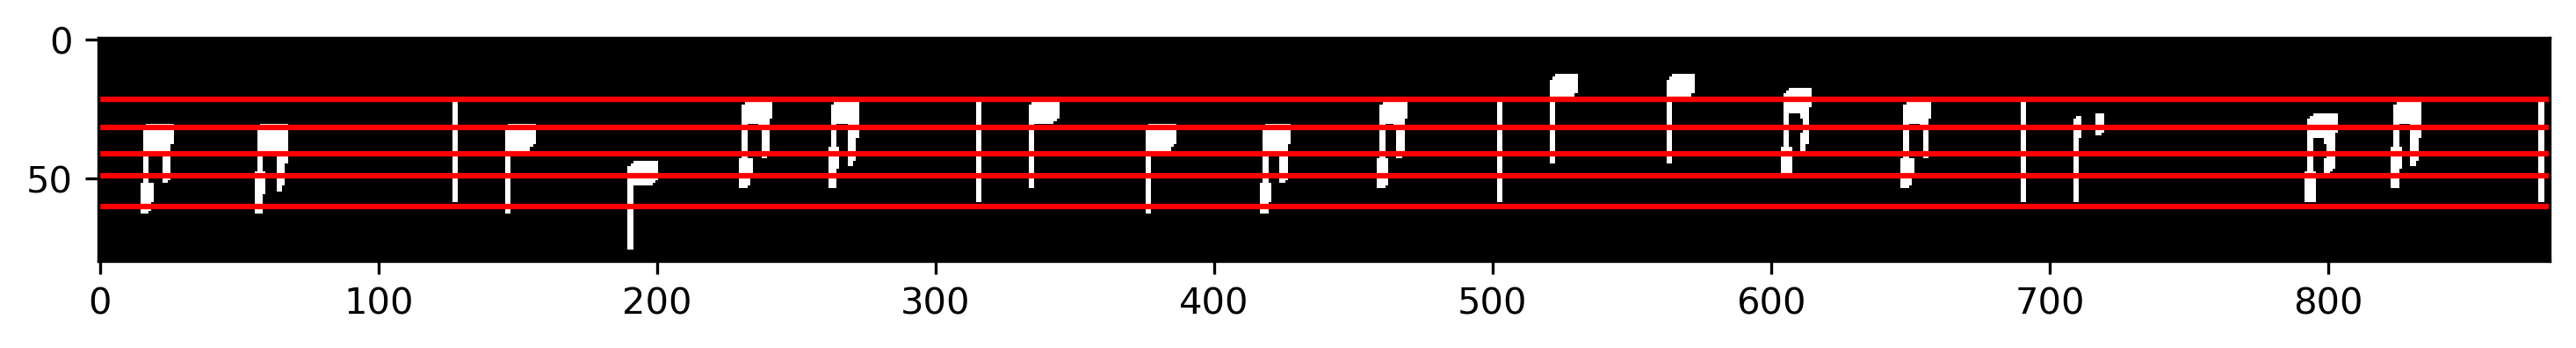

In [22]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
ax.imshow(line1, cmap='gray')

# Draw lines at the y-coordinates where you expect the centroids of the notes to be
y_coords = [21.5, 31.5, 41,  49, 60]
for y in y_coords:
    ax.axhline(y, color='r')

plt.show()

In [23]:
def define_pitch(number, dev=3):
#     number -= 0.25
    if 12.5-dev <= number <= 12.5+dev:
        return "A"
    elif 17.25-dev <= number <= 17.25+dev: 
        return "G"
    elif 21.5-dev <= number <= 21.5+dev: 
        return "F"
    elif 26.75-dev <= number <= 26.75+dev: 
        return "E"
    elif 31.5-dev <= number <= 31.5+dev: 
        return "D"
    elif 36.25-dev <= number <= 36.25+dev: 
        return "C"
    elif 41.0-dev <= number <= 41.0+dev: 
        return "B"
    elif 50.5-dev <= number <= 50.5+dev: 
        return "G"
    elif 45.75-dev <= number <= 45.75+dev: 
        return "A"
    elif 55.25-dev <= number <= 55.25+dev: 
        return "F"
    elif 60-dev <= number <= 60+dev: 
        return "E"
    elif 64.75-dev <= number <= 64.75+dev: 
        return "D"
    elif 69.5-dev <= number <= 69.5+dev: 
        return "C"


In [24]:
for x in blobs1:
    print(x[1])

36.0
36.0
35.0
48.0
27.0
27.0
26.0
35.0
36.0
27.0
17.0
17.0
23.0
27.0
32.0
27.0


<img src="read_music.png" width="300" />

['C', 'C', 'C', 'G', 'E', 'E', 'E', 'C', 'C', 'E', 'G', 'G', 'F', 'E', 'D', 'E']


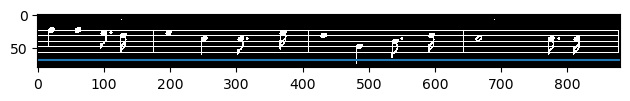

In [25]:
imshow(music_lines[1])
plt.axhline(69);
print([define_pitch(x[1]) for x in blobs1]) # C, C, C, G, E, E, E, C, C, E, G, G, F, E, D, D, E

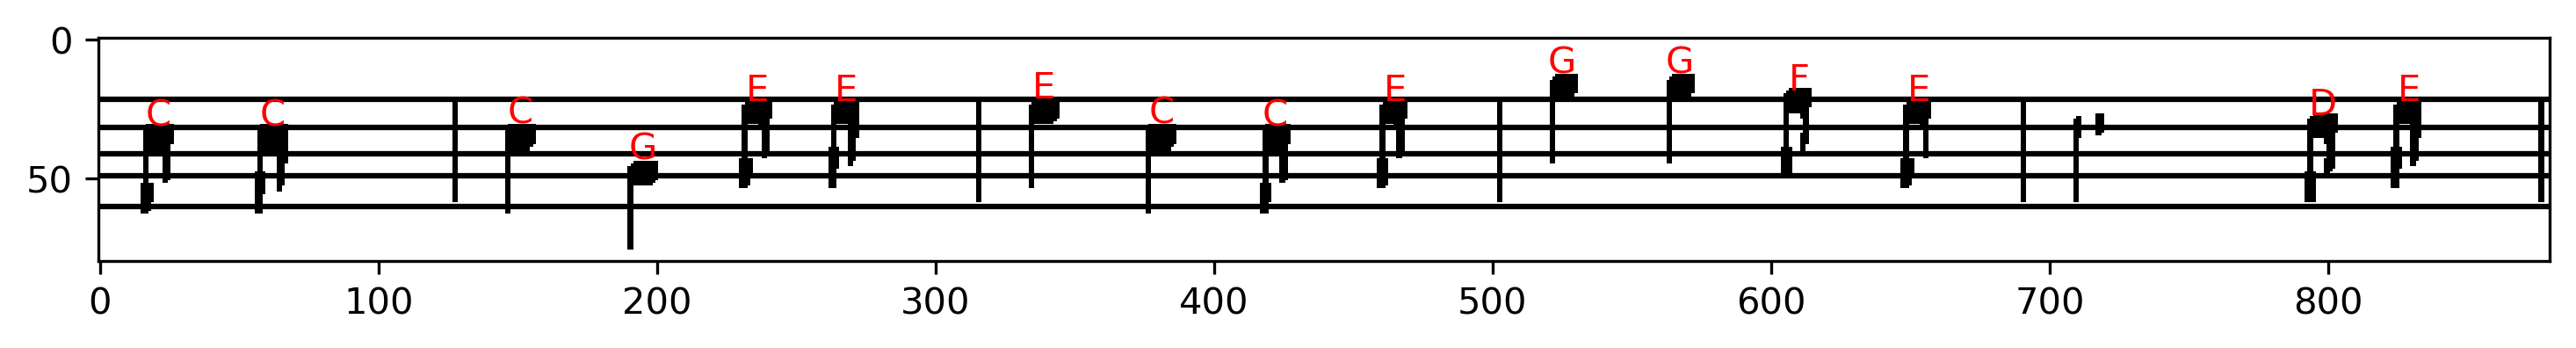

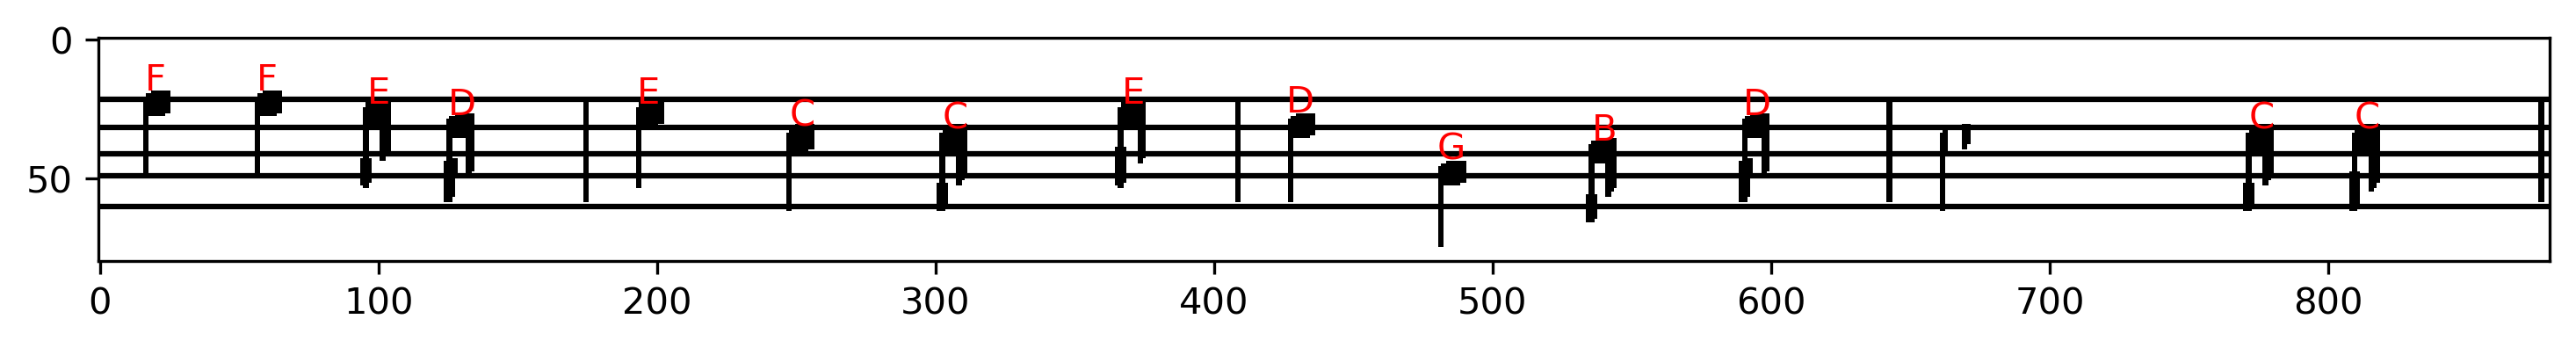

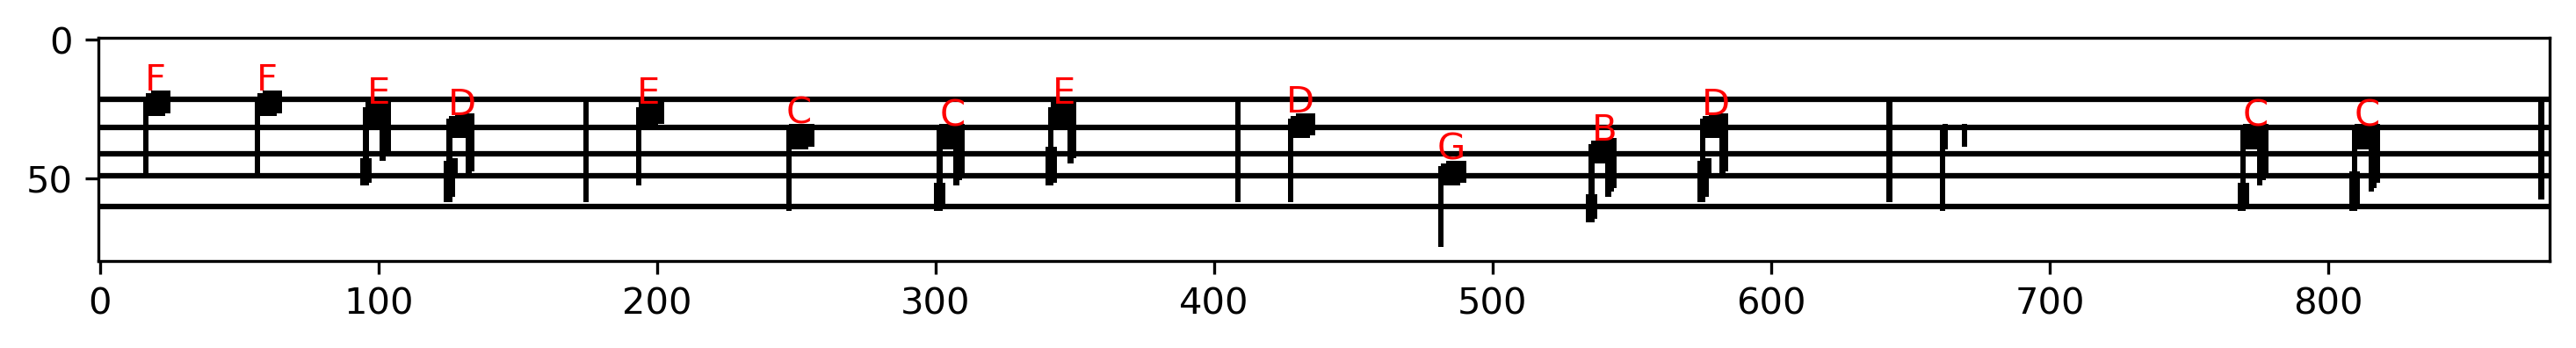

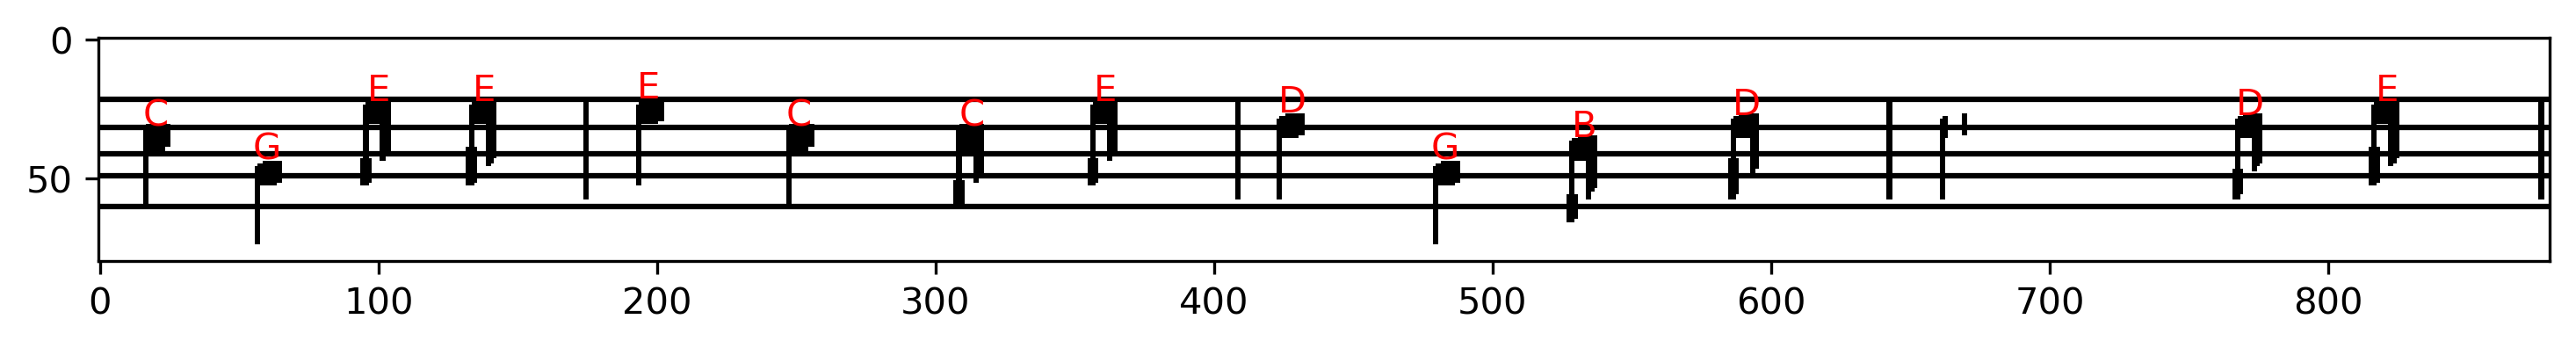

In [26]:
from skimage.util import invert

def print_sheet_and_pitches(line_image, blobs):
    line_image = invert(line_image)  # Add this line to invert the colors
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    ax.imshow(line_image, cmap='gray')

    # Draw lines at the y-coordinates where you expect the centroids of the notes to be
    y_coords = [21.5, 31.5, 41, 49, 60]
    for y in y_coords:
        ax.axhline(y, color='black')

    for blob in blobs:
        x, y = blob
        pitch = define_pitch(y)
        ax.text(x, y - 5, pitch, color='r', ha='center')

    plt.show()
    
def blob_detection(eroded_image):
    blobs = blob_dog(eroded_image, min_sigma=4.5, overlap=0.1, threshold=0.3)
    for blob in blobs:
        y, x, area = blob
        ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                                fill=False))
    blobs = [(xaxis, yaxis) for yaxis, xaxis, z in blobs]
    blobs = sorted(blobs, key=lambda x: x[0])
    return blobs

def process_music_sheet(image_path):
    music = rgb2gray(imread(image_path))
    music = music < 1
    template = music[140:220, 45:75]

    result = match_template(music, template)
    template_height, template_width  = template.shape
    music_lines = []
    for y, x in peak_local_max(result, threshold_abs=0.8):
        music_lines.append(music[y:y+template_height, 
                                 x+55:x+template_width+850+55])

    selem_stem = np.array([[0, 1, 0],
                           [0, 1, 0],
                           [0, 1, 0],
                           [0, 1, 0],
                           [0, 1, 0],
                           [0, 1, 0]])
    selem_bridge = np.ones((1, 4))
    selem_note = np.ones((2,2))

    for i, line in enumerate(music_lines):
        processed_line = im_dilation(im_closing(im_closing(im_opening(line, selem_stem, 1), selem_stem, 1),selem_bridge, 3), selem_note, 1)
        blobs = blob_detection(processed_line)
        print_sheet_and_pitches(processed_line, blobs)

# Run the function
process_music_sheet('Clementine.png')


# Beats

<img src="beats.jpg" width="300" />

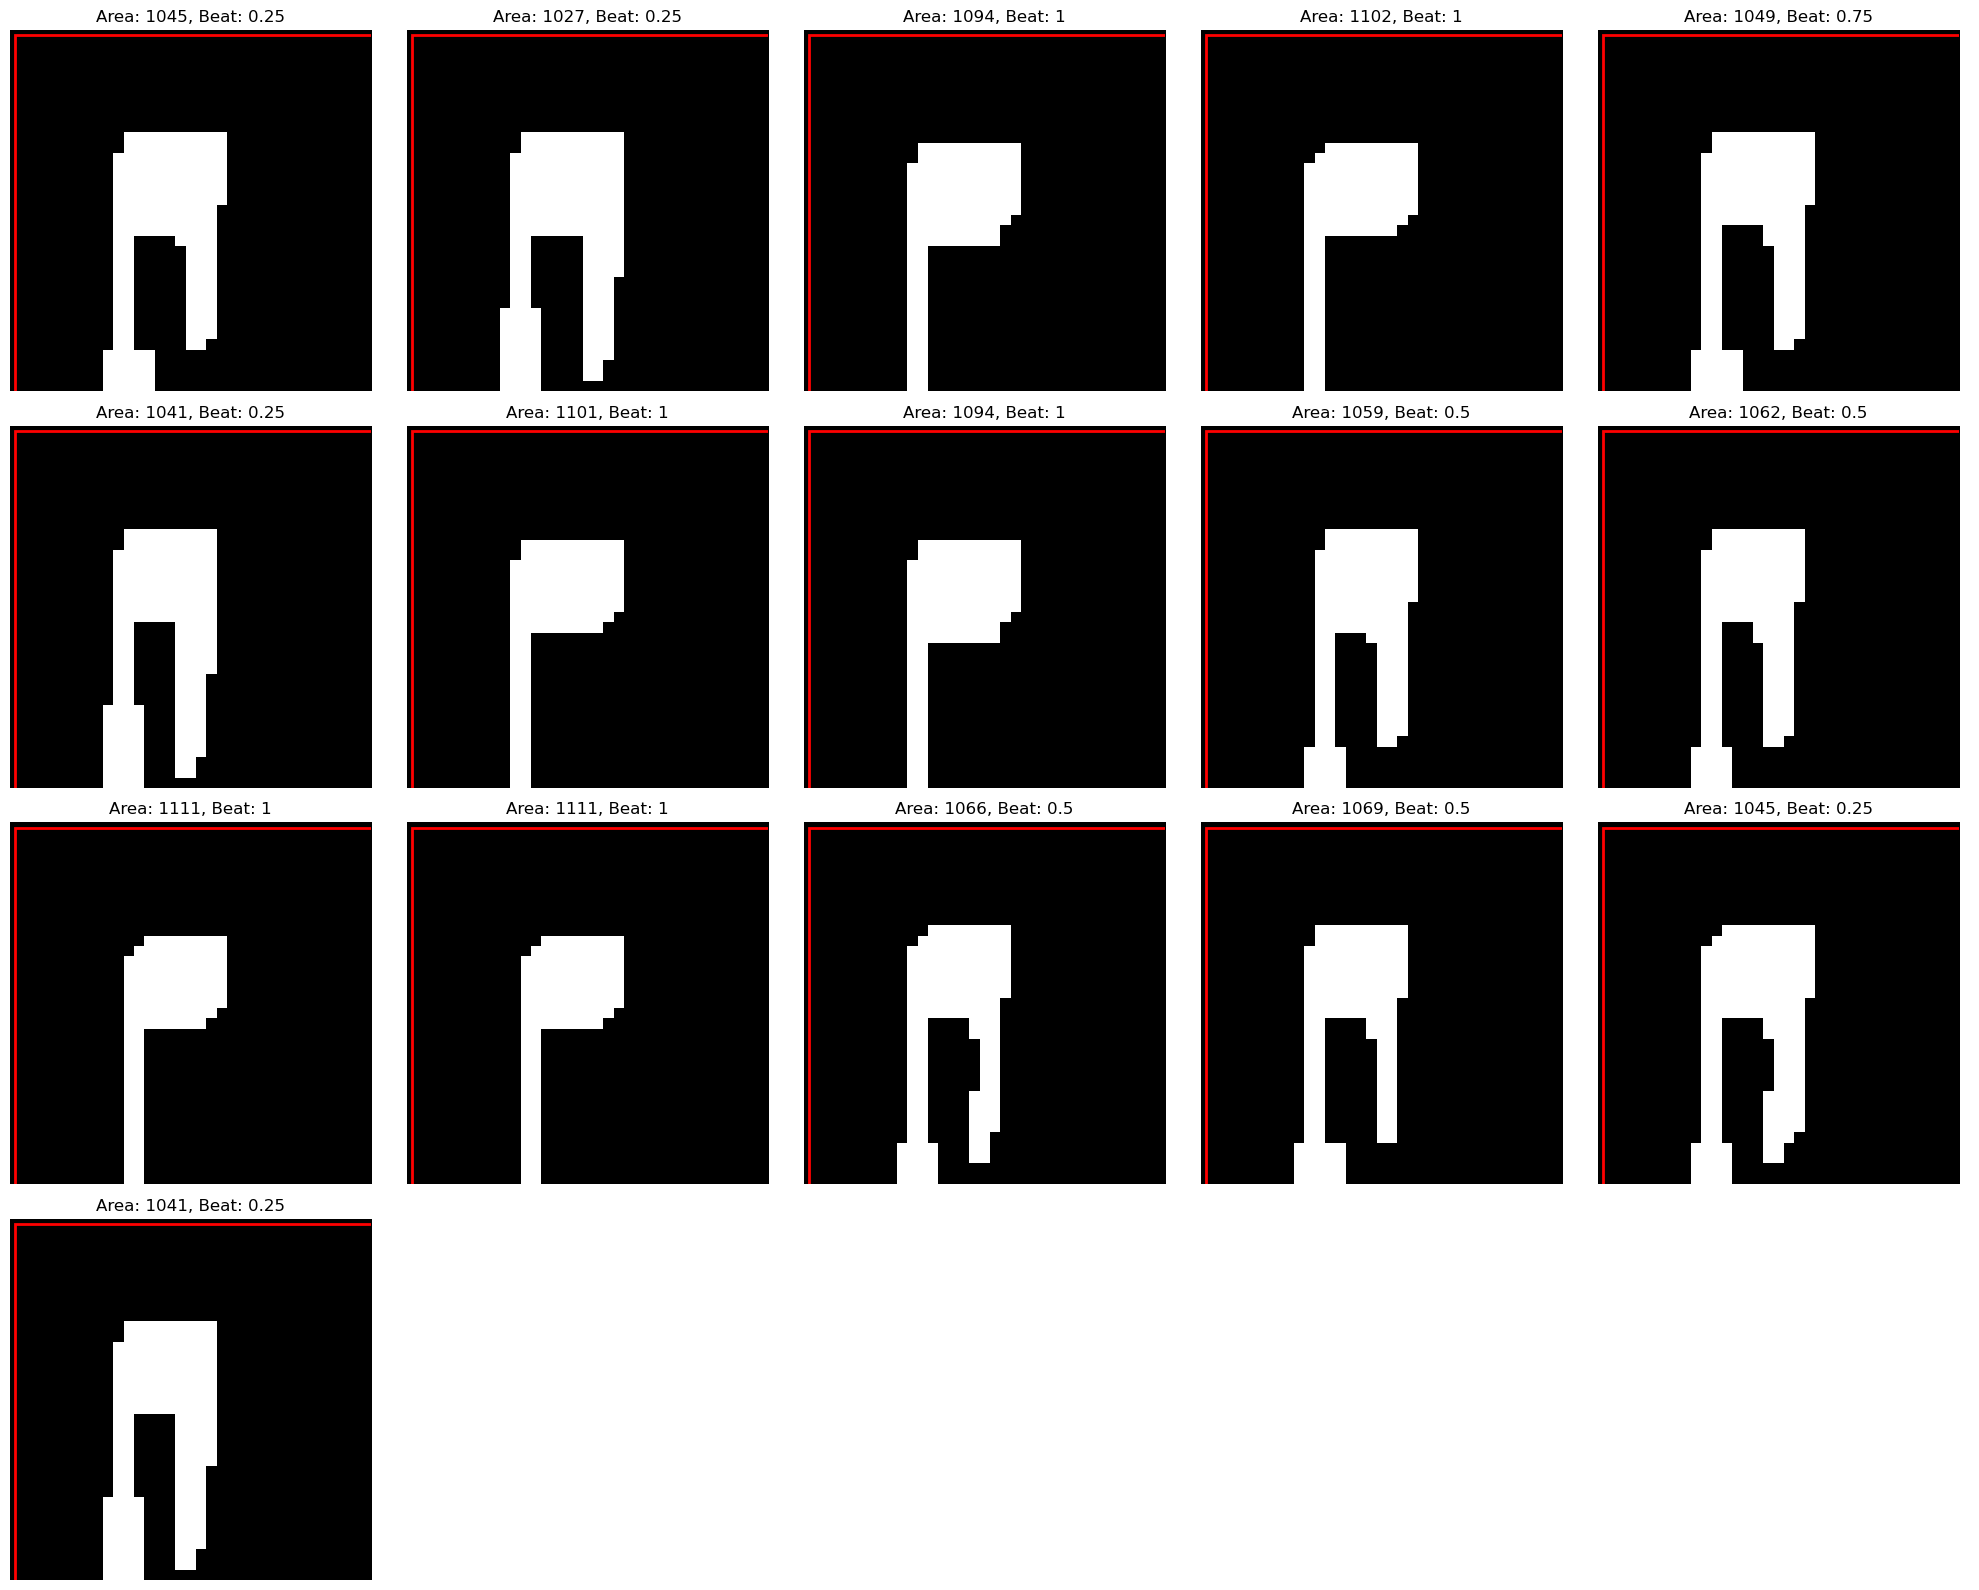

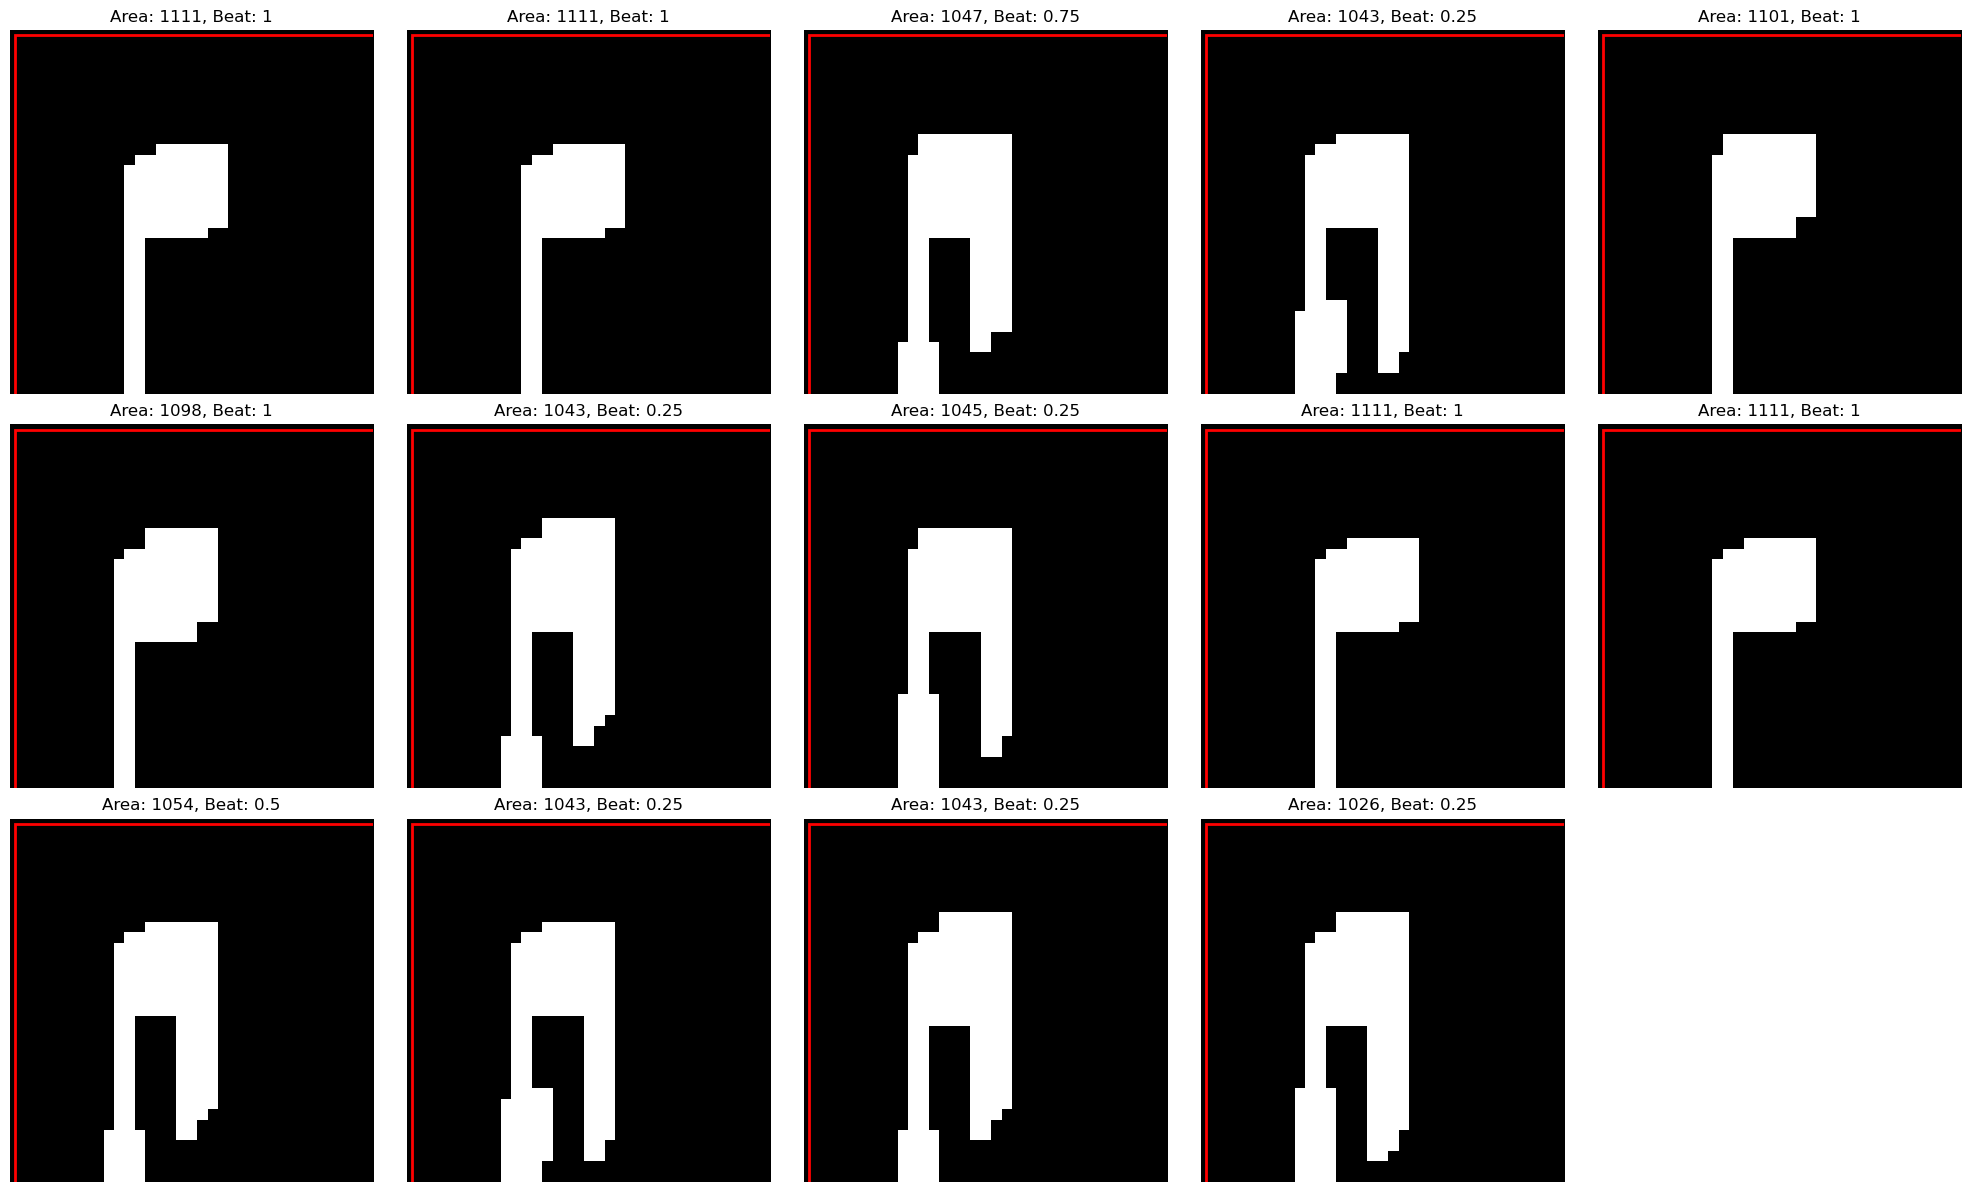

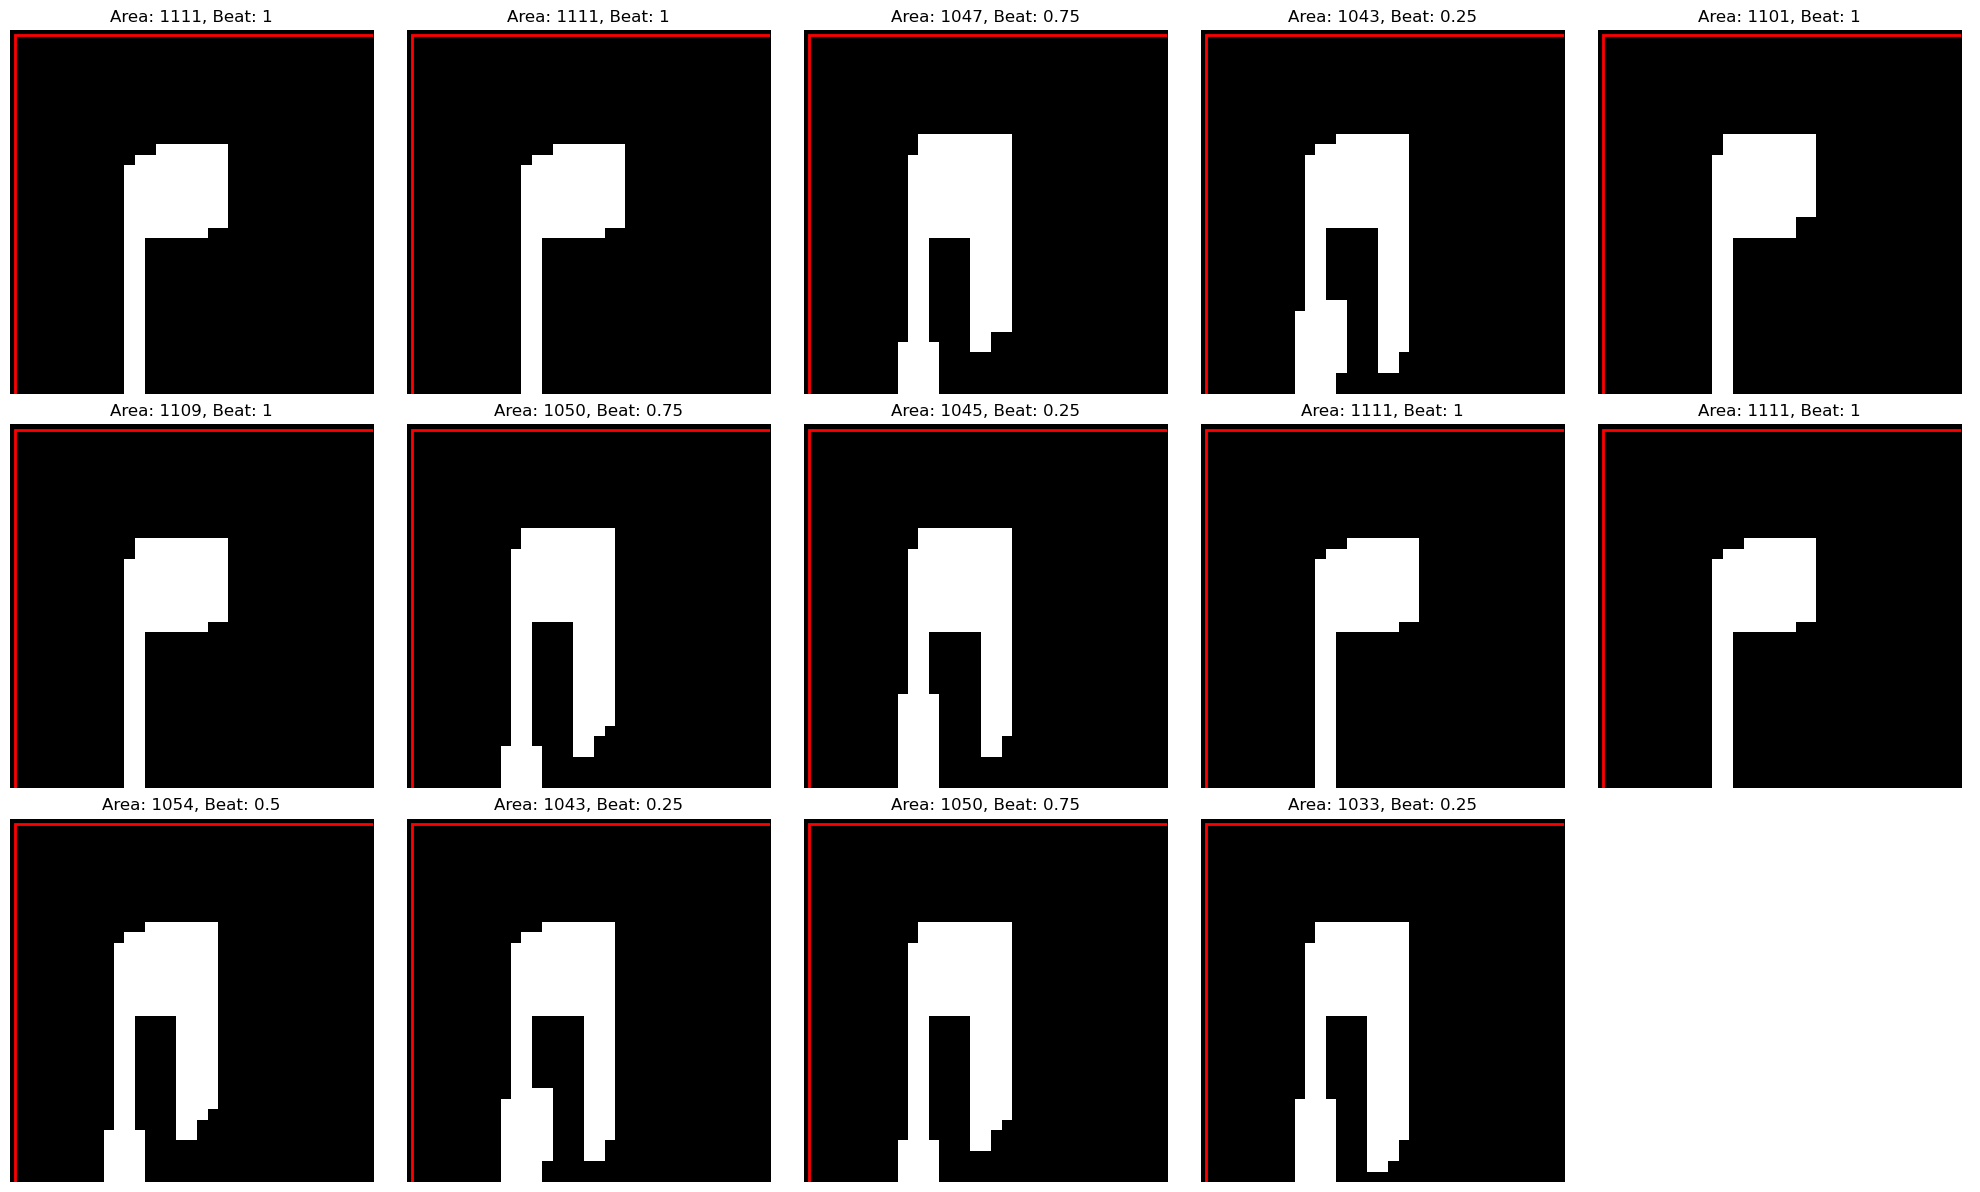

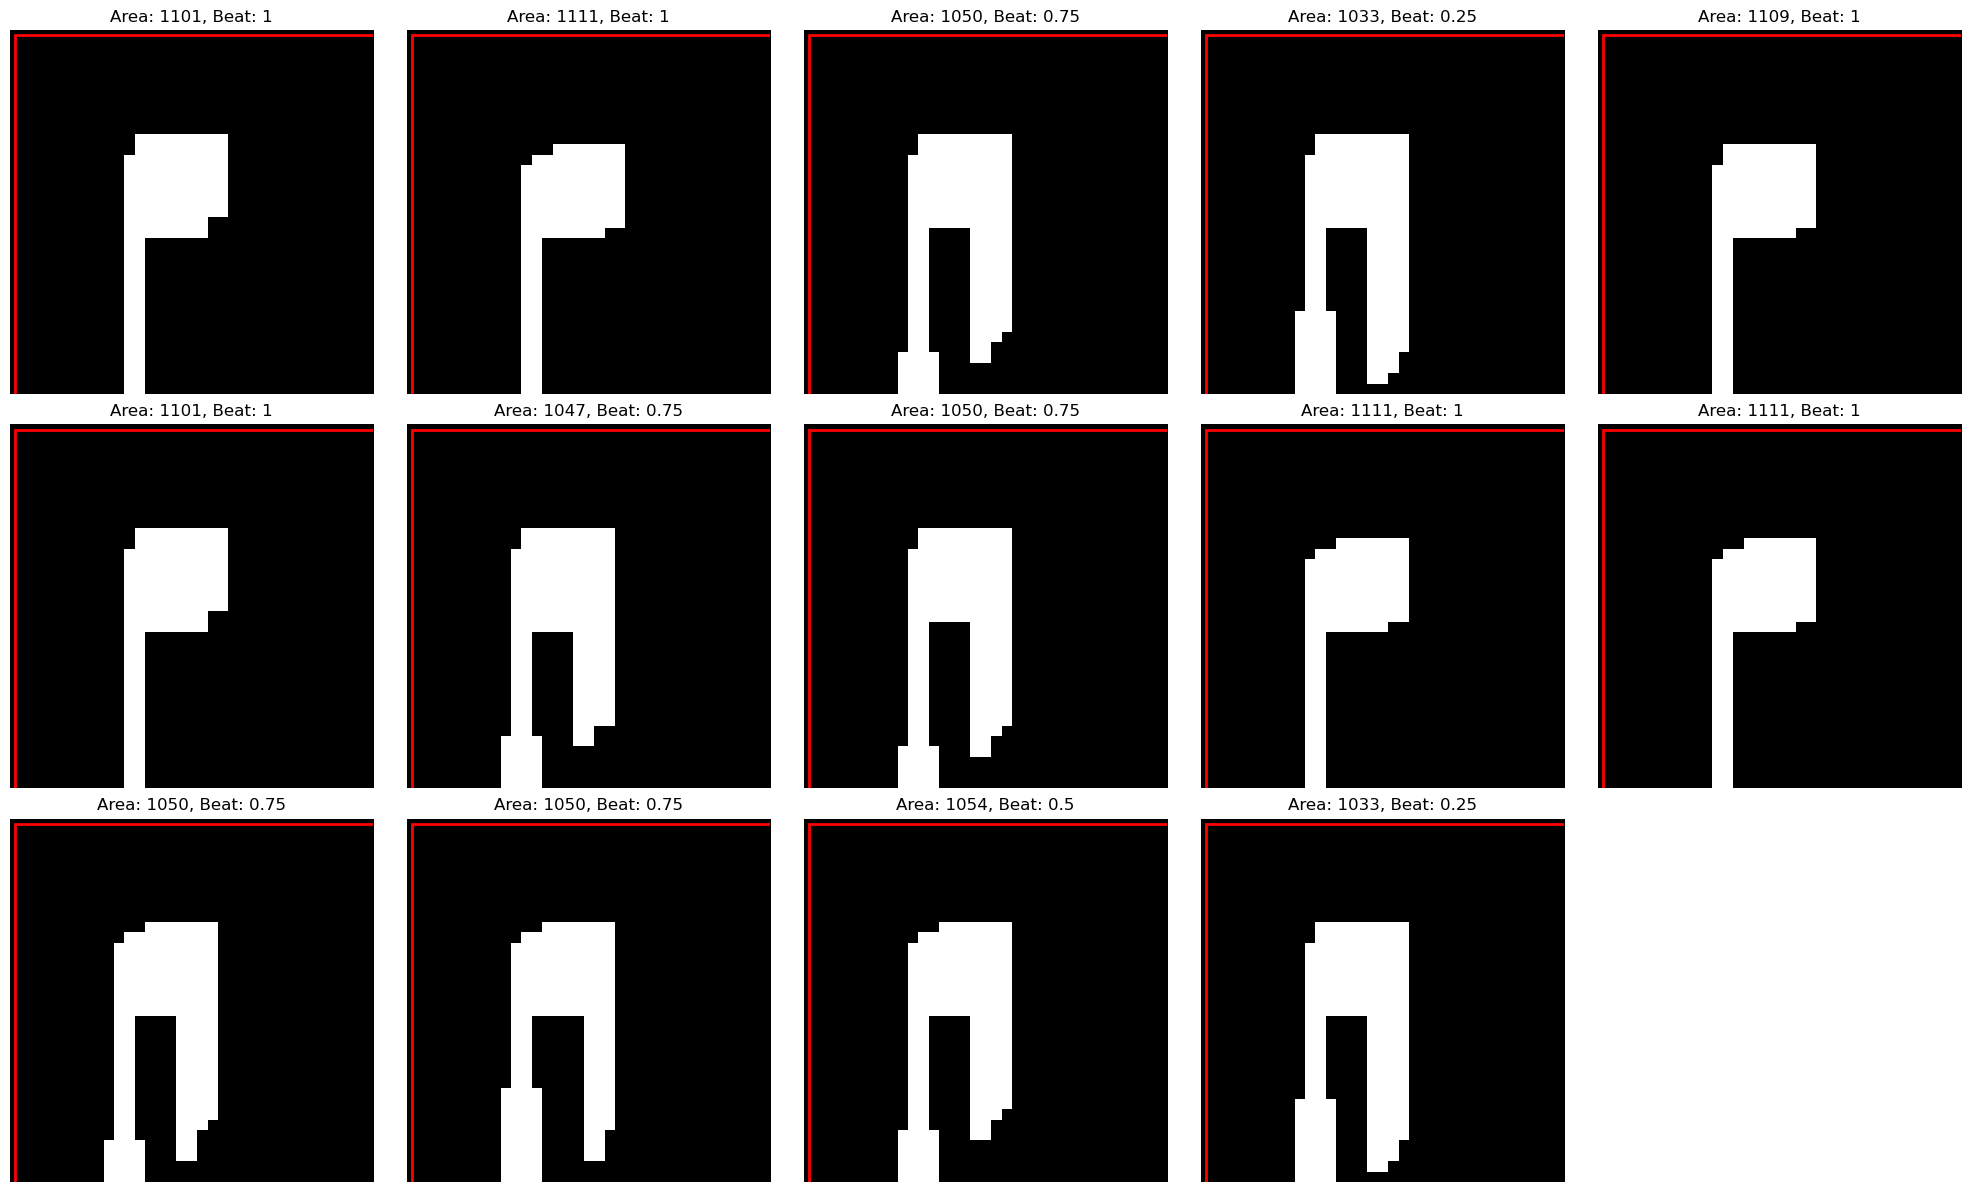

In [73]:
# lineb1 = im_closing(im_opening(music_lines[0], element, 1), element, 1)
# lineb2 = im_closing(im_opening(music_lines[0], element, 1), element, 1)
# lineb3 = im_closing(im_opening(music_lines[0], element, 1), element, 1)
# lineb4 = im_closing(im_opening(music_lines[0], element, 1), element, 1)
def define_beat(area):
    if area <= 1045:
        return 0.25  # 1/4 beat for small notes
    elif 1045 < area <= 1050:
        return 0.75  # 3/4 beat for medium notes
    elif 1050 < area <= 1080:
        return 0.5  # 1/2 beat for medium notes
    elif 1080 < area <= 2700:
        return 1  # 1 beat for medium notes
    else:
        return 2.0  # Two beats for large notes
    
def blob_properties(line_img, blobs):
    num_blobs = len(blobs)
    num_cols = min(num_blobs, 5)
    num_rows = (num_blobs + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()
    
    props = {}
    for num, data in enumerate(blobs):
        x, y = data  # Ignore the third element (area)
        note_image = line_img[int(y)-15:int(y)+20, int(x)-15:int(x)+20]
        
        label_im = label(invert(note_image))
        regions = regionprops(label_im)
        
        individual_areas = [x.area for x in regions]  # Calculate the areas of individual regions
        area = sum(individual_areas)  # Calculate the sum of areas for individual regions
        beat = define_beat(area)
        
        props[num] = {
            'area': area,
            'beat': beat,
            'individual_areas': individual_areas  # Store individual areas for comparison
        }
        
        ax = axes[num]
        ax.imshow(note_image, cmap='gray')
        ax.set_title(f'Area: {area}, Beat: {beat}')
        ax.axis('off')

        # Draw rectangles around the regions detected by regionprops
        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            rect = Rectangle((minc, minr), maxc - minc, maxr - minr,
                             fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
    
    # Hide empty subplots if there are fewer notes than the maximum per row
    for i in range(num_blobs, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(props).T


props1 = blob_properties(line1, blobs1)
props2 = blob_properties(line2, blobs2)
props3 = blob_properties(line3, blobs3)
props4 = blob_properties(line4, blobs4)

# Function

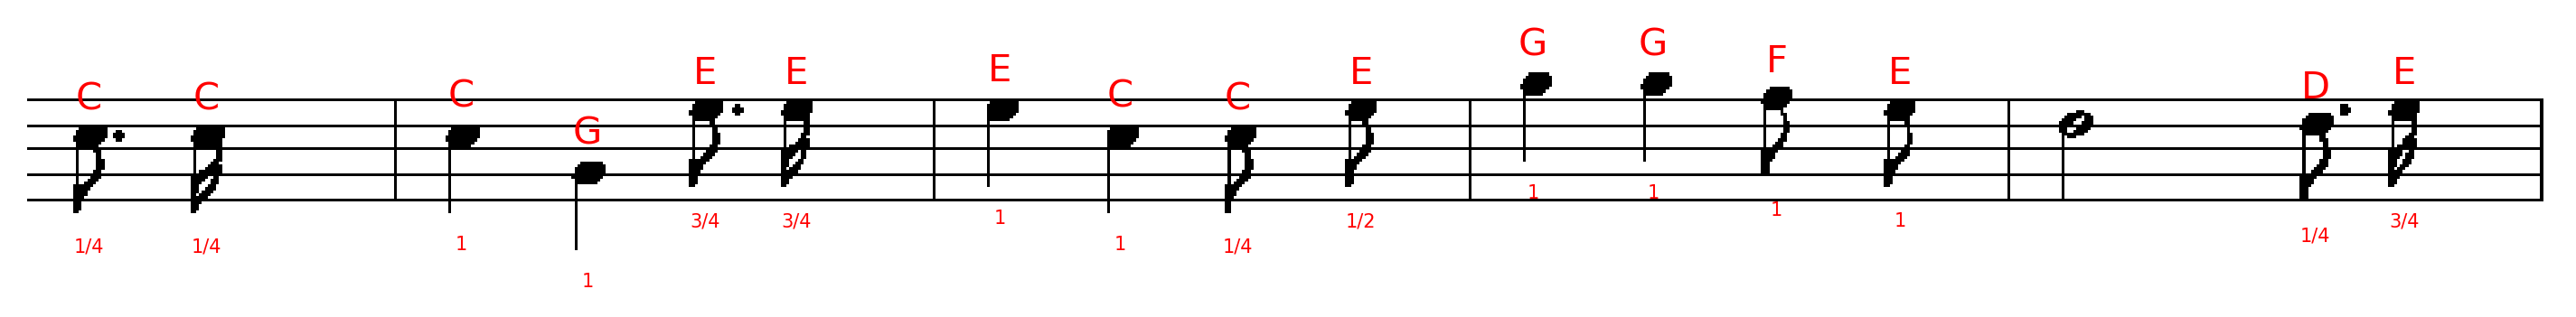

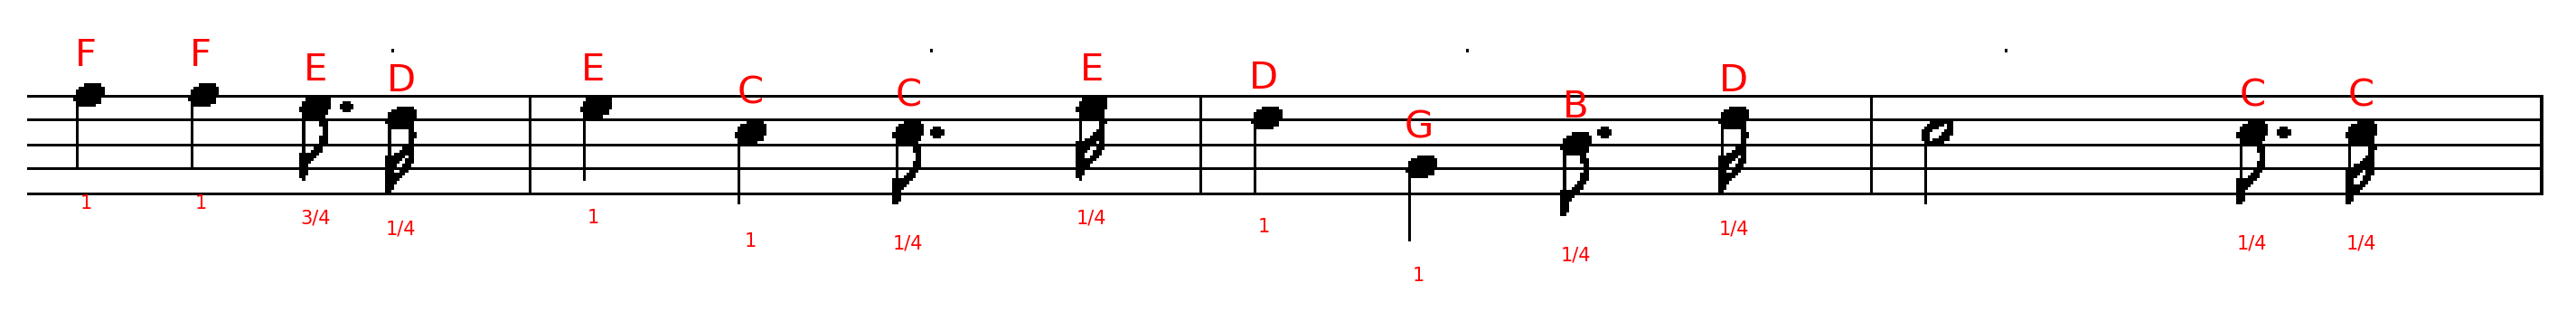

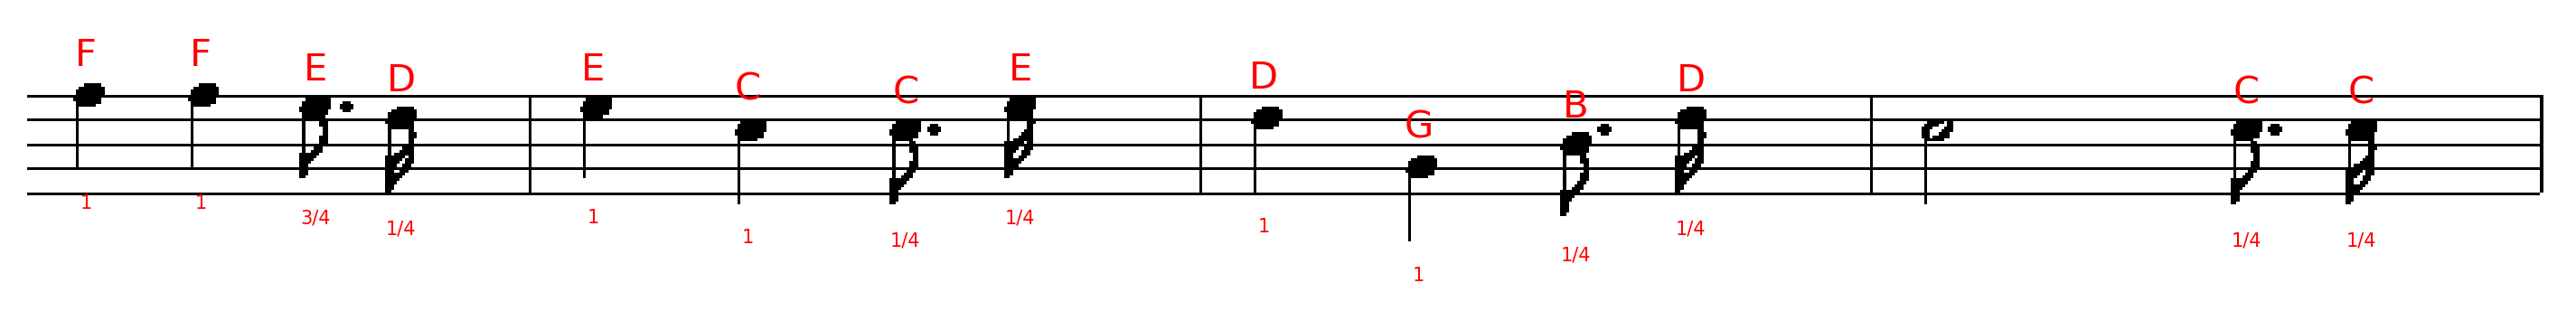

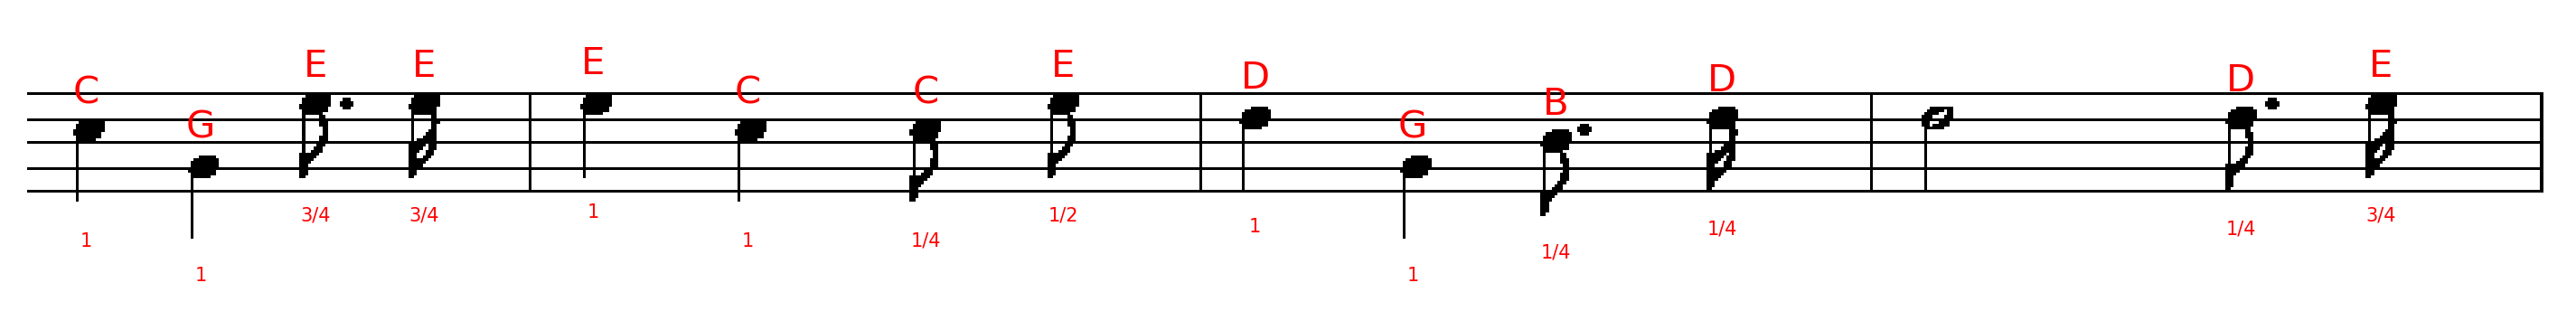

In [76]:
import numpy as np
from skimage.feature import peak_local_max, blob_dog
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage.io import imread, imshow
from skimage.morphology import opening, closing, dilation, erosion
from skimage.feature import match_template
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Morphological operation functions
def im_erosion(image, selem, n):
    for i in range(n):
        image = erosion(image, selem)
    return image

def im_dilation(image, selem, n):
    for i in range(n):
        image = dilation(image, selem)
    return image

def im_opening(image, selem, n):
    for i in range(n):
        image = opening(image, selem)
    return image

def im_closing(image, selem, n):
    for i in range(n):
        image = closing(image, selem)
    return image

# Defining pitches
def define_pitch(number, dev=3):
    if 12.5-dev <= number <= 12.5+dev:
        return "A"
    elif 17.25-dev <= number <= 17.25+dev: 
        return "G"
    elif 21.5-dev <= number <= 21.5+dev: 
        return "F"
    elif 26.75-dev <= number <= 26.75+dev: 
        return "E"
    elif 31.5-dev <= number <= 31.5+dev: 
        return "D"
    elif 36.25-dev <= number <= 36.25+dev: 
        return "C"
    elif 41.0-dev <= number <= 41.0+dev: 
        return "B"
    elif 50.5-dev <= number <= 50.5+dev: 
        return "G"
    elif 45.75-dev <= number <= 45.75+dev: 
        return "A"
    elif 55.25-dev <= number <= 55.25+dev: 
        return "F"
    elif 60-dev <= number <= 60+dev: 
        return "E"
    elif 64.75-dev <= number <= 64.75+dev: 
        return "D"
    elif 69.5-dev <= number <= 69.5+dev: 
        return "C"

def define_beat(area):
    if area <= 970:
        return 0.25  # 1/4 beat for small notes
    elif 970 < area <= 980:
        return 0.75  # 3/4 beat for medium notes
    elif 980 < area <= 999:
        return 0.5  # 1/2 beat for medium notes
    elif 999 < area <= 2700:
        return 1  # 1 beat for medium notes
    else:
        return 2.0  # Two beats for large notes
    

# Blob detection function
def blob_detection(eroded_image):
    blobs = blob_dog(eroded_image, min_sigma=4.5, overlap=0.1, threshold=0.3)
    blobs = [(x, y, area) for y, x, area in blobs]
    blobs = sorted(blobs, key=lambda x: x[0])
    return blobs

# Import the necessary library
from fractions import Fraction

def process_music_sheet(music, music_lines, selem_stem, selem_note):
    line_blobs = []
    for line in music_lines:
        line_processed = im_dilation(im_closing(im_opening(line, selem_stem, 1), selem_stem, 1), selem_note, 1)
        blobs = blob_detection(line_processed)
        line_blobs.append(blobs)

    # Iterate through each line of the music sheet
    for line_index, (line_img, blobs) in enumerate(zip(music_lines, line_blobs)):
        # Plot the image of the line
        fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
        ax.imshow(invert(line_img), cmap='gray')

        # Iterate through each blob (note) in the line
        for blob in blobs:
            x, y, _ = blob  # Ignore the third element (area)

            # Define the pitch based on the y-coordinate of the blob
            pitch = define_pitch(y)

            # Extract the note image for area calculation
            note_image = line_img[max(int(y)-15, 0):int(y)+20, max(int(x)-15, 0):int(x)+20]

            label_im = label(invert(note_image))
            regions = regionprops(label_im)

            area = sum(x.area for x in regions)
#             print(area)
            beat = define_beat(area)

            # Convert the beat to fraction format
            fraction = str(Fraction(beat).limit_denominator())

            # Plot the pitch above the note
            ax.text(x, y-10, pitch, color='red', fontsize=10, ha='center')
            # Plot the beat below the note
            ax.text(x, y+40, fraction, color='red', fontsize=5, ha='center')

        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Overlay the annotations on the original line image
        ax.imshow(invert(line_img), cmap='gray', alpha=0.3)

        # Show the plot for this line
        plt.show()


# Image reading and processing
music = rgb2gray(imread('Clementine.png'))
music = music < 1

# Define structural elements for morphological operations
selem_stem = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]])
selem_note = np.ones((2,2))

# Call the function to process the music sheet
process_music_sheet(music, music_lines, selem_stem, selem_note)

Questions:
1. What morphological operations did you use to clean the image?
1. How did you find the pitch?
1. How did you find the beat?
1. What are the challenges you've encounterd in performing the processing and how did you solve it?

## What morphological operations did you use to clean the image?
We used dilation, erosion, opening and closing. For the kernel we tried using a long vertical line so we can retain the majority of the notes and remove the horizontal lines along with the note stems. We created a series of experiments on which would provide the best output, from choosing the right kernel and to the combination of operations.

## How did you find the pitch?
A really hard practice, but though proper preprocessing of the image to leave only the notes, we were able to use blob detection to get the relative pixel position of the notes. Through this we generated our own horizontal lines that would be an indicator of what pitch the center of the blob is at, making it the pitch of that note. We experimented on the detection, whether to use log or dog, connected components was out of the question due to the half notes that are separated. In the end the dog proved to be more accurate with only the half notes being left out which we believe is the room for improvement in our paper.

## How did you find the beat?

This one is hard and done through rough assumptions. Base on the chart that was given, there is certain characteristics per note visually where halves are hollow and some have an extra stem or dot, we made use of the area per note that would be a determinant of their beat. It still needs some work but it managed to caputre a good number of the right beats per note. Unfortunately there are still challenges in this, especially when collating into a function along with the pitch the preprocessing seem to have affected the calculation of the beats which in turn made the range of area overlap and harder to differentiate.

## What are the challenges you've encounterd in performing the processing and how did you solve it?

Everything. From preprocessing of the notes, where we needed to find the right morphological operation that would be well fed to our blob detection. We had to be careful with the half note which unfortunately we ended up not being able to fix despite our best efforts. The preprocessing has lead to the disconnection of the half note's head which in turn was not able to detect in the blob detection portion. The other problem was the proper beat count. It was hard to determine how we could differentiate without using ML methods and settled with approximation of area per kind of note based on our samples. Lastly, we created both pitch and beat as separate functions and collating has caused problems with regards to the output of the beats.